In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as plty
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import catboost as cb
import shap

os.chdir('C:\\Users\\BTHANISH\\Documents\\Thanish\\Competition\\Analytics Vidya\\WNS')

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

# Reading the files and removing duplicates

In [24]:
train_prod_DF = pd.read_csv('train_LZdllcl.csv')
test_prod_DF = pd.read_csv('test_2umaH9m.csv')

print("The shape of train data is", train_prod_DF.shape)
print("The shape of test data is", test_prod_DF.shape)

test_prod_DF['is_promoted'] = None

cols_include = train_prod_DF.columns.difference(['employee_id', 'is_promoted'])

train_prod_DF = train_prod_DF.loc[~train_prod_DF[cols_include].duplicated(),]
print("The shape of train data after removing duplicates is", train_prod_DF.shape)

# sorting_columns = ['department', 'region', 'education', 'gender', 'recruitment_channel', 
#                    'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 
#                    'KPIs_met_grt_80', 'awards_won','avg_training_score', 'is_promoted']

# train_test_prod_check_duplicate = train_test_prod.sort_values(sorting_columns).copy()

# train_test_prod_check_duplicate['duplicated']= train_test_prod_check_duplicate[cols_include].duplicated()
# train_test_prod_check_duplicate.to_csv('check_duplicates.csv', index = False)

The shape of train data is (54808, 14)
The shape of test data is (23490, 13)
The shape of train data after removing duplicates is (54679, 14)


# Combining the train and test data

In [25]:
train_test_prod = train_prod_DF.append(test_prod_DF)
print("The shape of the combined data is", train_test_prod.shape)

train_test_prod.rename(columns = {'KPIs_met >80%' : 'KPIs_met_grt_80',
                                  'awards_won?' : 'awards_won'}, inplace = True)

train_test_prod.head()
print(train_test_prod.describe())
train_test_prod.tail()

The shape of the combined data is (78169, 14)
        employee_id  no_of_trainings           age  previous_year_rating  \
count  78169.000000     78169.000000  78169.000000          72299.000000   
mean   39145.267037         1.253566     34.806867              3.332259   
std    22603.483053         0.606938      7.665827              1.260945   
min        1.000000         1.000000     20.000000              1.000000   
25%    19570.000000         1.000000     29.000000              3.000000   
50%    39143.000000         1.000000     33.000000              3.000000   
75%    58716.000000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met_grt_80    awards_won  avg_training_score  
count       78169.000000     78169.000000  78169.000000        78169.000000  
mean            5.853625         0.354117      0.023091           63.354936  
std             4.248289         0.

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted
23485,53478,Legal,region_2,Below Secondary,m,sourcing,1,24,3.0,1,0,0,61,None
23486,25600,Technology,region_25,Bachelor's,m,sourcing,1,31,3.0,7,0,0,74,None
23487,45409,HR,region_16,Bachelor's,f,sourcing,1,26,4.0,4,0,0,50,None
23488,1186,Procurement,region_31,Bachelor's,m,sourcing,3,27,NaN,1,0,0,70,None
23489,5973,Technology,region_17,Master's & above,m,other,3,40,5.0,5,1,0,89,None


# Filling the NULL values in factor column

In [26]:
train_test_prod.education = train_test_prod.education.str.replace(" ", "_")
train_test_prod.education = train_test_prod.education.str.replace("'", "")
train_test_prod.education = train_test_prod.education.str.replace("&", "and")

print("Printing the values before imputing the NULL values", train_test_prod.education.isnull().value_counts())
train_test_prod.loc[train_test_prod.education.isnull(), ['education']] = 'Not_sure'

print("Printing the values after imputing the NULL values", train_test_prod.education.isnull().value_counts())

Printing the values before imputing the NULL values False    74738
True      3431
Name: education, dtype: int64
Printing the values after imputing the NULL values False    78169
Name: education, dtype: int64


# Filling the NULL values in integer column

In [27]:
train_test_prod.tail()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted
23485,53478,Legal,region_2,Below_Secondary,m,sourcing,1,24,3.0,1,0,0,61,None
23486,25600,Technology,region_25,Bachelors,m,sourcing,1,31,3.0,7,0,0,74,None
23487,45409,HR,region_16,Bachelors,f,sourcing,1,26,4.0,4,0,0,50,None
23488,1186,Procurement,region_31,Bachelors,m,sourcing,3,27,NaN,1,0,0,70,None
23489,5973,Technology,region_17,Masters_and_above,m,other,3,40,5.0,5,1,0,89,None


In [28]:
train_test_prod.fillna(-999, inplace = True)
#print(train_test_prod.describe())
train_test_prod.tail()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted
23485,53478,Legal,region_2,Below_Secondary,m,sourcing,1,24,3.0,1,0,0,61,-999
23486,25600,Technology,region_25,Bachelors,m,sourcing,1,31,3.0,7,0,0,74,-999
23487,45409,HR,region_16,Bachelors,f,sourcing,1,26,4.0,4,0,0,50,-999
23488,1186,Procurement,region_31,Bachelors,m,sourcing,3,27,-999.0,1,0,0,70,-999
23489,5973,Technology,region_17,Masters_and_above,m,other,3,40,5.0,5,1,0,89,-999


# Find all the categorical columns

In [29]:
#train_prod.dtypes
cat_columns = train_test_prod.select_dtypes(include = ['object']).columns.tolist()
cat_columns

['department', 'region', 'education', 'gender', 'recruitment_channel']

# Feature enigneering
   # Extract the region number from region

In [30]:
train_test_prod['region'] = train_test_prod['region'].str.replace("region_", "").astype('int')
train_test_prod.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,7,Masters_and_above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,22,Bachelors,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,19,Bachelors,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,23,Bachelors,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,26,Bachelors,m,other,1,45,3.0,2,0,0,73,0


# Feature enigneering

    # Training score per training
    # % time spent in the company

In [31]:
train_test_prod['score_per_training'] = train_test_prod['avg_training_score']/train_test_prod['no_of_trainings']
train_test_prod['per_age_in_this_company'] = train_test_prod['length_of_service']/train_test_prod['age']
train_test_prod['Rating_per_service'] = train_test_prod['previous_year_rating']/train_test_prod['length_of_service']
#train_test_prod['KPI_mul_avg_score'] = train_test_prod['KPIs_met_grt_80'] * train_test_prod['avg_training_score']
#train_test_prod['training_vs_service'] = train_test_prod['no_of_trainings']/train_test_prod['length_of_service']

train_test_prod.tail()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted,score_per_training,per_age_in_this_company,Rating_per_service
23485,53478,Legal,2,Below_Secondary,m,sourcing,1,24,3.0,1,0,0,61,-999,61.000000,0.041667,3.000000
23486,25600,Technology,25,Bachelors,m,sourcing,1,31,3.0,7,0,0,74,-999,74.000000,0.225806,0.428571
23487,45409,HR,16,Bachelors,f,sourcing,1,26,4.0,4,0,0,50,-999,50.000000,0.153846,1.000000
23488,1186,Procurement,31,Bachelors,m,sourcing,3,27,-999.0,1,0,0,70,-999,23.333333,0.037037,-999.000000
23489,5973,Technology,17,Masters_and_above,m,other,3,40,5.0,5,1,0,89,-999,29.666667,0.125000,1.000000


# Splitting back to prod train and test

In [32]:
train_prod = train_test_prod.loc[train_test_prod.is_promoted != -999, ]
test_prod = train_test_prod.loc[train_test_prod.is_promoted == -999, ]

print("The shape of train_prod", train_prod.shape)
print("The shape of test_prod", test_prod.shape)

sub_id = test_prod.employee_id

train_prod.drop(['employee_id'], axis = 1, inplace = True)
test_prod.drop(['employee_id'], axis = 1, inplace = True)

train_prod.head()

The shape of train_prod (54679, 17)
The shape of test_prod (23490, 17)


C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted,score_per_training,per_age_in_this_company,Rating_per_service
0,Sales & Marketing,7,Masters_and_above,f,sourcing,1,35,5.0,8,1,0,49,0,49.0,0.228571,0.625000
1,Operations,22,Bachelors,m,other,1,30,5.0,4,0,0,60,0,60.0,0.133333,1.250000
2,Sales & Marketing,19,Bachelors,m,sourcing,1,34,3.0,7,0,0,50,0,50.0,0.205882,0.428571
3,Sales & Marketing,23,Bachelors,m,other,2,39,1.0,10,0,0,50,0,25.0,0.256410,0.100000
4,Technology,26,Bachelors,m,other,1,45,3.0,2,0,0,73,0,73.0,0.044444,1.500000


# Label encode the categorical variables

In [33]:
cols_2_encode = train_prod.columns[train_prod.dtypes == 'object']
cols_2_encode = cols_2_encode.difference(['region'])
print("columns to encode", cols_2_encode)

le = LabelEncoder()
train_prod.loc[:, cols_2_encode] = train_prod.loc[:, cols_2_encode].apply(lambda x : le.fit_transform(x))
train_prod.tail()

test_prod.loc[:, cols_2_encode] = test_prod.loc[:, cols_2_encode].apply(lambda x : le.fit_transform(x))
test_prod.tail()





# #Department
# encode_department = train_prod.groupby(['department']).agg({'is_promoted' : ['mean']}).reset_index()
# encode_department.columns = ['department', 'department_mean']

# train_prod = pd.merge(train_prod, encode_department[['department', 'department_mean']], 
#                         how = 'left', on = 'department').drop(['department'], axis = 1)
# test_prod = pd.merge(test_prod, encode_department[['department', 'department_mean']], 
#                         how = 'left', on = 'department').drop(['department'], axis = 1)


# #Education
# encode_education = train_prod.groupby(['education']).agg({'is_promoted' : ['mean']}).reset_index()
# encode_education.columns = ['education', 'education_mean']

# train_prod = pd.merge(train_prod, encode_education[['education', 'education_mean']], 
#                         how = 'left', on = 'education').drop(['education'], axis = 1)
# test_prod = pd.merge(test_prod, encode_education[['education', 'education_mean']], 
#                         how = 'left', on = 'education').drop(['education'], axis = 1)

# #Gender
# encode_gender = train_prod.groupby(['gender']).agg({'is_promoted' : ['mean']}).reset_index()
# encode_gender.columns = ['gender', 'gender_mean']

# train_prod = pd.merge(train_prod, encode_gender[['gender', 'gender_mean']], 
#                         how = 'left', on = 'gender').drop(['gender'], axis = 1)
# test_prod = pd.merge(test_prod, encode_gender[['gender', 'gender_mean']], 
#                         how = 'left', on = 'gender').drop(['gender'], axis = 1)

# #recruitment_channel
# encode_recruitment_channel = train_prod.groupby(['recruitment_channel']).agg({'is_promoted' : ['mean']}).reset_index()
# encode_recruitment_channel.columns = ['recruitment_channel', 'recruitment_channel_mean']

# train_prod = pd.merge(train_prod, encode_recruitment_channel[['recruitment_channel', 'recruitment_channel_mean']], 
#                         how = 'left', on = 'recruitment_channel').drop(['recruitment_channel'], axis = 1)
# test_prod = pd.merge(test_prod, encode_recruitment_channel[['recruitment_channel', 'recruitment_channel_mean']], 
#                         how = 'left', on = 'recruitment_channel').drop(['recruitment_channel'], axis = 1)


# #region
# # encode_region = train_prod.groupby(['region']).agg({'is_promoted' : ['mean']}).reset_index()
# # encode_region.columns = ['region', 'region_mean']

# # train_prod = pd.merge(train_prod, encode_region[['region', 'region_mean']], 
# #                         how = 'left', on = 'region').drop(['region'], axis = 1)
# # test_prod = pd.merge(test_prod, encode_region[['region', 'region_mean']], 
# #                         how = 'left', on = 'region').drop(['region'], axis = 1)

print("train prod")
train_prod.head()

columns to encode Index(['department', 'education', 'gender', 'recruitment_channel'], dtype='object')


C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



train prod


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted,score_per_training,per_age_in_this_company,Rating_per_service
0,7,7,2,0,2,1,35,5.0,8,1,0,49,0,49.0,0.228571,0.625000
1,4,22,0,1,0,1,30,5.0,4,0,0,60,0,60.0,0.133333,1.250000
2,7,19,0,1,2,1,34,3.0,7,0,0,50,0,50.0,0.205882,0.428571
3,7,23,0,1,0,2,39,1.0,10,0,0,50,0,25.0,0.256410,0.100000
4,8,26,0,1,0,1,45,3.0,2,0,0,73,0,73.0,0.044444,1.500000


# Kmeans cluster

In [34]:

train_prod_cluster = train_prod.copy()
test_prod_cluster = test_prod.copy()

#Scaling the features
cols_2_use_and_scale = train_prod_cluster.columns.difference(['is_promoted'])
scaler = MinMaxScaler()
scaler.fit(train_prod_cluster.loc[:,cols_2_use_and_scale])

#Scaling the train and test prod
train_prod_cluster.loc[:,cols_2_use_and_scale] = scaler.transform(train_prod_cluster.loc[:,cols_2_use_and_scale])
test_prod_cluster[cols_2_use_and_scale] = scaler.transform(test_prod_cluster[cols_2_use_and_scale])

#Fit the model on the train prod
np.random.seed(100)
clus = KMeans(n_clusters= 25, random_state= 123)

#train_prod_cluster.drop(['cluster'], axis = 1, inplace = True)
#test_prod_cluster.drop(['cluster'], axis = 1, inplace = True)

clus.fit(X=train_prod_cluster[cols_2_use_and_scale])

train_prod['cluster'] = clus.labels_

#Predict on the test prod
test_prod['cluster'] = clus.predict(test_prod_cluster[cols_2_use_and_scale])


C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [35]:
print(train_prod.groupby(['cluster']).agg({'is_promoted':['count', 'mean']}))
print(test_prod.groupby(['cluster']).agg({'is_promoted':['count', 'mean']}))

        is_promoted          
              count      mean
cluster                      
0              3021  0.034757
1              3975  0.041509
2              1489  0.164540
3              2653  0.040332
4              3484  0.170494
5               476  0.073529
6              1377  0.154684
7              1895  0.059103
8              5540  0.030686
9              2088  0.036398
10             3609  0.159878
11             3926  0.039480
12              839  0.042908
13             2425  0.168247
14             1343  0.055101
15              674  0.084570
16             1061  0.035815
17             1473  0.049559
18             1713  0.185639
19             1849  0.171444
20             1817  0.040726
21             1008  0.168651
22             1560  0.060897
23             1881  0.186603
24             3503  0.027976
        is_promoted     
              count mean
cluster                 
0              1304 -999
1              1652 -999
2               677 -999
3         

# Feature engineering

In [36]:
trian_rating_service_group = train_prod.groupby(['previous_year_rating', 'Rating_per_service']).agg({'is_promoted':['sum', 'count']}).reset_index()
trian_rating_service_group.columns = ['previous_year_rating',
                                      'Rating_per_service',
                                      'is_promoted_sum', 'record_count']
trian_rating_service_group['promoted_ratio'] = trian_rating_service_group['is_promoted_sum']/trian_rating_service_group['record_count']
trian_rating_service_group

train_prod = pd.merge(train_prod, 
                      trian_rating_service_group[['previous_year_rating','Rating_per_service', 'promoted_ratio']], 
                      how = 'left',
                      on = ['previous_year_rating','Rating_per_service'])

test_prod = pd.merge(test_prod, 
                     trian_rating_service_group[['previous_year_rating','Rating_per_service', 'promoted_ratio']], 
                     how = 'left',
                     on = ['previous_year_rating','Rating_per_service'])

In [37]:
train_prod.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_grt_80,awards_won,avg_training_score,is_promoted,score_per_training,per_age_in_this_company,Rating_per_service,cluster,promoted_ratio
0,7,7,2,0,2,1,35,5.0,8,1,0,49,0,49.0,0.228571,0.625000,13,0.182979
1,4,22,0,1,0,1,30,5.0,4,0,0,60,0,60.0,0.133333,1.250000,24,0.167506
2,7,19,0,1,2,1,34,3.0,7,0,0,50,0,50.0,0.205882,0.428571,8,0.074510
3,7,23,0,1,0,2,39,1.0,10,0,0,50,0,25.0,0.256410,0.100000,24,0.025180
4,8,26,0,1,0,1,45,3.0,2,0,0,73,0,73.0,0.044444,1.500000,24,0.074547


# Splitting to local train and test

In [38]:
dep = 'is_promoted'
indep = train_prod.columns.difference([dep])
print("The indep columns are ", indep)

train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]
    
np.random.seed(100)
train_local_X, test_local_X, train_local_Y, test_local_Y = train_test_split(train_prod_X,
                                                                            train_prod_Y,
                                                                            test_size = 0.7,
                                                                            stratify = train_prod[dep]
                                                                            )

print("The shape of X train", train_local_X.shape) 
print("The shape of Y train", train_local_Y.shape)
print("The shape of X test", test_local_X.shape)
print("The shape of Y test", test_local_Y.shape )

The indep columns are  Index(['KPIs_met_grt_80', 'Rating_per_service', 'age', 'avg_training_score',
       'awards_won', 'cluster', 'department', 'education', 'gender',
       'length_of_service', 'no_of_trainings', 'per_age_in_this_company',
       'previous_year_rating', 'promoted_ratio', 'recruitment_channel',
       'region', 'score_per_training'],
      dtype='object')
The shape of X train (16403, 17)
The shape of Y train (16403,)
The shape of X test (38276, 17)
The shape of Y test (38276,)


# LGBM Grid search -II

In [39]:
#XGBoost
lgb_train_prod = lgb.Dataset(train_prod_X, train_prod_Y,
                            categorical_feature = cat_columns,
                            free_raw_data=False )

                            

#Cross validation
depth_search = [3, 4, 5]
eta_search = [0.08, 0.09, 0.1, 1.1 ]
subsample_search = [0.7, 0.8, 0.9, 1]
colsample_search = [0.8, 0.9, 1]


def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    labels = (labels>0.3).astype(int)
    preds  = (preds>0.3).astype(int)
    #print(labels)
    #print(preds)
    f_score = f1_score(preds, labels , average = 'binary')
    return 'f1_score', f_score, True


best_iteration = []
best_auc = []
best_depth = []
best_LR = []
best_sub_samp = []
best_col_samp = []

model_count = len(depth_search) * len(eta_search)  * len(subsample_search) * len(colsample_search)
count = 0
num_round = 1000

for depth in depth_search :
    for LR in eta_search :
        for sub_samp in subsample_search :
            for col_samp in colsample_search :
                
                print("Model", count, "out of", model_count) 
                params = {'boosting_type': 'gbdt',
                          'objective': 'binary',
                          #'metric': 'binary_logloss',
                          'num_leaves': 2**depth,
                          'max_depth' : depth,
                          'learning_rate': LR,
                          'feature_fraction': col_samp,
                          'bagging_fraction': sub_samp,
                          #'bagging_freq': 5,
                          'verbose': 1
                         }
                
                #Cross validation
                np.random.seed(100)
                lgbm_local = lgb.cv(params,
                                    lgb_train_prod,
                                    nfold = 5,
                                    num_boost_round = num_round,
                                    feval = evalerror,
                                    verbose_eval = 1,
                                    #valid_sets=lgb_valid_local,
                                    early_stopping_rounds = 20)
                
                error_array = np.array(lgbm_local['f1_score-mean'])
                
                best_valid_score = error_array.max()
                best_round = np.where(error_array == best_valid_score)
                best_round = best_round[0].tolist()[0]
                
                print("Model", count, "out of", model_count, "Best round", best_round, "Score", best_valid_score) 
                    
                best_iteration.append(best_round)                
                best_auc.append(best_valid_score)
                best_depth.append(depth)
                best_LR.append(LR)
                best_sub_samp.append(sub_samp)
                best_col_samp.append(col_samp)
                
                count += 1

cv_DF = pd.DataFrame({'iter' : best_iteration,
                      'depth' : best_depth,
                      'LR' : best_LR,
                      'sub_samp' : best_sub_samp,
                      'col_samp' : best_col_samp,
                      'Auc' : best_auc})

cv_DF.loc[cv_DF['Auc'] == cv_DF['Auc'].max(),:]           


Model 0 out of 144


C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning:

Using categorical_feature in Dataset.



[1]	cv_agg's binary_logloss: 0.636895 + 0.000137083	cv_agg's f1_score: 0.157157 + 6.75946e-05
[2]	cv_agg's binary_logloss: 0.58933 + 0.000207731	cv_agg's f1_score: 0.157157 + 6.75946e-05
[3]	cv_agg's binary_logloss: 0.547774 + 0.000310769	cv_agg's f1_score: 0.157157 + 6.75946e-05
[4]	cv_agg's binary_logloss: 0.512181 + 0.000365173	cv_agg's f1_score: 0.157157 + 6.75946e-05
[5]	cv_agg's binary_logloss: 0.480971 + 0.000460882	cv_agg's f1_score: 0.157157 + 6.75946e-05
[6]	cv_agg's binary_logloss: 0.453551 + 0.000549496	cv_agg's f1_score: 0.157157 + 6.75946e-05
[7]	cv_agg's binary_logloss: 0.429435 + 0.000654167	cv_agg's f1_score: 0.282845 + 0.00288111
[8]	cv_agg's binary_logloss: 0.408432 + 0.000684838	cv_agg's f1_score: 0.309013 + 0.0045051
[9]	cv_agg's binary_logloss: 0.389851 + 0.000755941	cv_agg's f1_score: 0.316573 + 0.00806776
[10]	cv_agg's binary_logloss: 0.372837 + 0.000817088	cv_agg's f1_score: 0.325195 + 0.011815
[11]	cv_agg's binary_logloss: 0.357724 + 0.000886696	cv_agg's f1_sc

[21]	cv_agg's binary_logloss: 0.268351 + 0.00110661	cv_agg's f1_score: 0.276953 + 0.0123538
[22]	cv_agg's binary_logloss: 0.263579 + 0.0010581	cv_agg's f1_score: 0.275913 + 0.0106856
[23]	cv_agg's binary_logloss: 0.259326 + 0.00109347	cv_agg's f1_score: 0.276268 + 0.0104645
[24]	cv_agg's binary_logloss: 0.254961 + 0.00135478	cv_agg's f1_score: 0.282331 + 0.0131617
[25]	cv_agg's binary_logloss: 0.250603 + 0.00147968	cv_agg's f1_score: 0.284982 + 0.0110654
[26]	cv_agg's binary_logloss: 0.246862 + 0.00177997	cv_agg's f1_score: 0.288527 + 0.0151729
[27]	cv_agg's binary_logloss: 0.243398 + 0.00165673	cv_agg's f1_score: 0.287743 + 0.00827094
[28]	cv_agg's binary_logloss: 0.23997 + 0.00150793	cv_agg's f1_score: 0.290773 + 0.00911424
[29]	cv_agg's binary_logloss: 0.236848 + 0.00122913	cv_agg's f1_score: 0.289047 + 0.010146
[30]	cv_agg's binary_logloss: 0.234247 + 0.00129338	cv_agg's f1_score: 0.287025 + 0.013159
[31]	cv_agg's binary_logloss: 0.231304 + 0.00123108	cv_agg's f1_score: 0.297261 + 

[9]	cv_agg's binary_logloss: 0.388657 + 0.000891201	cv_agg's f1_score: 0.298075 + 0.00654044
[10]	cv_agg's binary_logloss: 0.371686 + 0.000920319	cv_agg's f1_score: 0.328098 + 0.00628783
[11]	cv_agg's binary_logloss: 0.356447 + 0.000984535	cv_agg's f1_score: 0.329291 + 0.0213282
[12]	cv_agg's binary_logloss: 0.342723 + 0.000952237	cv_agg's f1_score: 0.303672 + 0.0138219
[13]	cv_agg's binary_logloss: 0.330565 + 0.0009697	cv_agg's f1_score: 0.298223 + 0.0126246
[14]	cv_agg's binary_logloss: 0.319559 + 0.0010031	cv_agg's f1_score: 0.28979 + 0.0114366
[15]	cv_agg's binary_logloss: 0.309764 + 0.00103208	cv_agg's f1_score: 0.287733 + 0.0123504
[16]	cv_agg's binary_logloss: 0.300891 + 0.00102131	cv_agg's f1_score: 0.284309 + 0.0141131
[17]	cv_agg's binary_logloss: 0.292988 + 0.00100693	cv_agg's f1_score: 0.283356 + 0.0123814
[18]	cv_agg's binary_logloss: 0.285828 + 0.0010058	cv_agg's f1_score: 0.280068 + 0.0127911
[19]	cv_agg's binary_logloss: 0.2794 + 0.00100212	cv_agg's f1_score: 0.277953 +

[3]	cv_agg's binary_logloss: 0.532647 + 0.000414776	cv_agg's f1_score: 0.157157 + 6.75946e-05
[4]	cv_agg's binary_logloss: 0.494677 + 0.0005467	cv_agg's f1_score: 0.157157 + 6.75946e-05
[5]	cv_agg's binary_logloss: 0.462182 + 0.000647663	cv_agg's f1_score: 0.157157 + 6.75946e-05
[6]	cv_agg's binary_logloss: 0.434053 + 0.000699452	cv_agg's f1_score: 0.284663 + 0.00328591
[7]	cv_agg's binary_logloss: 0.40947 + 0.000862579	cv_agg's f1_score: 0.29645 + 0.00588456
[8]	cv_agg's binary_logloss: 0.388016 + 0.000936472	cv_agg's f1_score: 0.298049 + 0.00648317
[9]	cv_agg's binary_logloss: 0.369134 + 0.00105789	cv_agg's f1_score: 0.330963 + 0.00454344
[10]	cv_agg's binary_logloss: 0.352269 + 0.00103004	cv_agg's f1_score: 0.310053 + 0.0204591
[11]	cv_agg's binary_logloss: 0.337416 + 0.000968274	cv_agg's f1_score: 0.302907 + 0.0139267
[12]	cv_agg's binary_logloss: 0.32434 + 0.00105927	cv_agg's f1_score: 0.291825 + 0.0109747
[13]	cv_agg's binary_logloss: 0.31286 + 0.00105006	cv_agg's f1_score: 0.288

[29]	cv_agg's binary_logloss: 0.228882 + 0.00210025	cv_agg's f1_score: 0.324161 + 0.0242558
Model 22 out of 144 Best round 8 Score 0.333910942069
Model 23 out of 144
[1]	cv_agg's binary_logloss: 0.629961 + 0.000156923	cv_agg's f1_score: 0.157157 + 6.75946e-05
[2]	cv_agg's binary_logloss: 0.57723 + 0.000303471	cv_agg's f1_score: 0.157157 + 6.75946e-05
[3]	cv_agg's binary_logloss: 0.532647 + 0.000414776	cv_agg's f1_score: 0.157157 + 6.75946e-05
[4]	cv_agg's binary_logloss: 0.494677 + 0.0005467	cv_agg's f1_score: 0.157157 + 6.75946e-05
[5]	cv_agg's binary_logloss: 0.462182 + 0.000647663	cv_agg's f1_score: 0.157157 + 6.75946e-05
[6]	cv_agg's binary_logloss: 0.434053 + 0.000699452	cv_agg's f1_score: 0.284663 + 0.00328591
[7]	cv_agg's binary_logloss: 0.40947 + 0.000862579	cv_agg's f1_score: 0.29645 + 0.00588456
[8]	cv_agg's binary_logloss: 0.388016 + 0.000936472	cv_agg's f1_score: 0.298049 + 0.00648317
[9]	cv_agg's binary_logloss: 0.369134 + 0.00105789	cv_agg's f1_score: 0.330963 + 0.0045434

[89]	cv_agg's binary_logloss: 0.176218 + 0.00139669	cv_agg's f1_score: 0.49254 + 0.00841988
[90]	cv_agg's binary_logloss: 0.175944 + 0.00157061	cv_agg's f1_score: 0.492931 + 0.00789333
[91]	cv_agg's binary_logloss: 0.175392 + 0.00153584	cv_agg's f1_score: 0.495159 + 0.00694218
[92]	cv_agg's binary_logloss: 0.174968 + 0.00124977	cv_agg's f1_score: 0.495844 + 0.00669577
[93]	cv_agg's binary_logloss: 0.174834 + 0.00114081	cv_agg's f1_score: 0.496615 + 0.00553317
[94]	cv_agg's binary_logloss: 0.174813 + 0.00114875	cv_agg's f1_score: 0.496251 + 0.00474022
[95]	cv_agg's binary_logloss: 0.174532 + 0.000995562	cv_agg's f1_score: 0.497496 + 0.00485071
[96]	cv_agg's binary_logloss: 0.174422 + 0.00102121	cv_agg's f1_score: 0.498702 + 0.00561734
[97]	cv_agg's binary_logloss: 0.174095 + 0.00113448	cv_agg's f1_score: 0.49946 + 0.00556754
[98]	cv_agg's binary_logloss: 0.173835 + 0.00113749	cv_agg's f1_score: 0.499013 + 0.00567066
[99]	cv_agg's binary_logloss: 0.173681 + 0.00113742	cv_agg's f1_score: 

[12]	cv_agg's binary_logloss: 0.308986 + 0.000999143	cv_agg's f1_score: 0.290144 + 0.0092585
[13]	cv_agg's binary_logloss: 0.298494 + 0.00108887	cv_agg's f1_score: 0.289242 + 0.0103437
[14]	cv_agg's binary_logloss: 0.28891 + 0.00108411	cv_agg's f1_score: 0.282828 + 0.0127761
[15]	cv_agg's binary_logloss: 0.280551 + 0.00108091	cv_agg's f1_score: 0.278629 + 0.0135774
[16]	cv_agg's binary_logloss: 0.273225 + 0.00104942	cv_agg's f1_score: 0.277522 + 0.0122666
[17]	cv_agg's binary_logloss: 0.267308 + 0.00109239	cv_agg's f1_score: 0.278639 + 0.0128693
[18]	cv_agg's binary_logloss: 0.26154 + 0.00114331	cv_agg's f1_score: 0.280711 + 0.0122095
[19]	cv_agg's binary_logloss: 0.25575 + 0.0017249	cv_agg's f1_score: 0.300658 + 0.0255342
[20]	cv_agg's binary_logloss: 0.250559 + 0.00150476	cv_agg's f1_score: 0.299245 + 0.0247626
[21]	cv_agg's binary_logloss: 0.247107 + 0.0015383	cv_agg's f1_score: 0.30228 + 0.0243764
[22]	cv_agg's binary_logloss: 0.243496 + 0.00158343	cv_agg's f1_score: 0.304437 + 0.0

[159]	cv_agg's binary_logloss: 0.166589 + 0.000720369	cv_agg's f1_score: 0.51822 + 0.0046859
[160]	cv_agg's binary_logloss: 0.166563 + 0.000703673	cv_agg's f1_score: 0.518347 + 0.00487045
[161]	cv_agg's binary_logloss: 0.166571 + 0.00068238	cv_agg's f1_score: 0.518407 + 0.00453273
[162]	cv_agg's binary_logloss: 0.166514 + 0.000714473	cv_agg's f1_score: 0.519122 + 0.00400135
[163]	cv_agg's binary_logloss: 0.166469 + 0.000703984	cv_agg's f1_score: 0.518979 + 0.00355723
[164]	cv_agg's binary_logloss: 0.166433 + 0.000737216	cv_agg's f1_score: 0.518553 + 0.00387716
[165]	cv_agg's binary_logloss: 0.166381 + 0.000786764	cv_agg's f1_score: 0.519614 + 0.00504335
[166]	cv_agg's binary_logloss: 0.166312 + 0.000788207	cv_agg's f1_score: 0.520384 + 0.00551027
[167]	cv_agg's binary_logloss: 0.166268 + 0.000807212	cv_agg's f1_score: 0.520472 + 0.00537816
[168]	cv_agg's binary_logloss: 0.166258 + 0.000795089	cv_agg's f1_score: 0.520487 + 0.0052052
[169]	cv_agg's binary_logloss: 0.166224 + 0.000839531	

[54]	cv_agg's binary_logloss: 0.194949 + 0.00125389	cv_agg's f1_score: 0.416896 + 0.011555
[55]	cv_agg's binary_logloss: 0.194105 + 0.00159832	cv_agg's f1_score: 0.418348 + 0.0119448
[56]	cv_agg's binary_logloss: 0.193347 + 0.00117915	cv_agg's f1_score: 0.421064 + 0.0146751
[57]	cv_agg's binary_logloss: 0.192115 + 0.000990955	cv_agg's f1_score: 0.427981 + 0.0111029
[58]	cv_agg's binary_logloss: 0.191639 + 0.000720618	cv_agg's f1_score: 0.429326 + 0.00984423
[59]	cv_agg's binary_logloss: 0.190972 + 0.000994794	cv_agg's f1_score: 0.432853 + 0.00878607
[60]	cv_agg's binary_logloss: 0.189768 + 0.000829768	cv_agg's f1_score: 0.439817 + 0.00895294
[61]	cv_agg's binary_logloss: 0.188894 + 0.000784134	cv_agg's f1_score: 0.441492 + 0.00826557
[62]	cv_agg's binary_logloss: 0.188032 + 0.0012472	cv_agg's f1_score: 0.44691 + 0.0116078
[63]	cv_agg's binary_logloss: 0.187175 + 0.00105314	cv_agg's f1_score: 0.451261 + 0.0129081
[64]	cv_agg's binary_logloss: 0.186808 + 0.00121242	cv_agg's f1_score: 0.4

[142]	cv_agg's binary_logloss: 0.168003 + 0.000974552	cv_agg's f1_score: 0.514197 + 0.00391611
[143]	cv_agg's binary_logloss: 0.167967 + 0.00101468	cv_agg's f1_score: 0.514714 + 0.00414639
[144]	cv_agg's binary_logloss: 0.167886 + 0.00105104	cv_agg's f1_score: 0.514776 + 0.00445365
[145]	cv_agg's binary_logloss: 0.167767 + 0.00105958	cv_agg's f1_score: 0.514834 + 0.00454621
[146]	cv_agg's binary_logloss: 0.167646 + 0.000944959	cv_agg's f1_score: 0.515921 + 0.00479616
[147]	cv_agg's binary_logloss: 0.167546 + 0.000892357	cv_agg's f1_score: 0.515643 + 0.00433839
[148]	cv_agg's binary_logloss: 0.16744 + 0.000837003	cv_agg's f1_score: 0.516202 + 0.00471344
[149]	cv_agg's binary_logloss: 0.167317 + 0.000868002	cv_agg's f1_score: 0.515827 + 0.00493626
[150]	cv_agg's binary_logloss: 0.167164 + 0.00078784	cv_agg's f1_score: 0.516607 + 0.00409902
[151]	cv_agg's binary_logloss: 0.167124 + 0.000792137	cv_agg's f1_score: 0.516451 + 0.00412211
[152]	cv_agg's binary_logloss: 0.167073 + 0.000810114	c

[36]	cv_agg's binary_logloss: 0.210683 + 0.00193264	cv_agg's f1_score: 0.353224 + 0.0162119
[37]	cv_agg's binary_logloss: 0.209646 + 0.00170592	cv_agg's f1_score: 0.357505 + 0.0170558
[38]	cv_agg's binary_logloss: 0.208742 + 0.00183683	cv_agg's f1_score: 0.357597 + 0.0176858
[39]	cv_agg's binary_logloss: 0.207682 + 0.0018192	cv_agg's f1_score: 0.360722 + 0.0188477
[40]	cv_agg's binary_logloss: 0.20673 + 0.00175128	cv_agg's f1_score: 0.364176 + 0.0174095
[41]	cv_agg's binary_logloss: 0.206 + 0.00174991	cv_agg's f1_score: 0.36822 + 0.0143203
[42]	cv_agg's binary_logloss: 0.204793 + 0.00179647	cv_agg's f1_score: 0.369121 + 0.0147386
[43]	cv_agg's binary_logloss: 0.203373 + 0.0022458	cv_agg's f1_score: 0.379545 + 0.01516
[44]	cv_agg's binary_logloss: 0.202777 + 0.00225743	cv_agg's f1_score: 0.377749 + 0.0143933
[45]	cv_agg's binary_logloss: 0.20147 + 0.00178248	cv_agg's f1_score: 0.386966 + 0.0179209
[46]	cv_agg's binary_logloss: 0.20081 + 0.00187104	cv_agg's f1_score: 0.388516 + 0.0162286

[210]	cv_agg's binary_logloss: 0.165224 + 0.00104664	cv_agg's f1_score: 0.52179 + 0.00460276
[211]	cv_agg's binary_logloss: 0.165213 + 0.00109227	cv_agg's f1_score: 0.521284 + 0.00459513
[212]	cv_agg's binary_logloss: 0.165199 + 0.00110165	cv_agg's f1_score: 0.522336 + 0.00481572
[213]	cv_agg's binary_logloss: 0.165173 + 0.00112526	cv_agg's f1_score: 0.522834 + 0.00503534
[214]	cv_agg's binary_logloss: 0.165083 + 0.00111442	cv_agg's f1_score: 0.522584 + 0.00464406
[215]	cv_agg's binary_logloss: 0.165001 + 0.00117595	cv_agg's f1_score: 0.522639 + 0.00448123
[216]	cv_agg's binary_logloss: 0.164948 + 0.00121861	cv_agg's f1_score: 0.522818 + 0.00475437
[217]	cv_agg's binary_logloss: 0.164885 + 0.00126898	cv_agg's f1_score: 0.522598 + 0.00486596
[218]	cv_agg's binary_logloss: 0.164786 + 0.00129165	cv_agg's f1_score: 0.523027 + 0.00502524
[219]	cv_agg's binary_logloss: 0.164722 + 0.00129246	cv_agg's f1_score: 0.523427 + 0.00494568
[220]	cv_agg's binary_logloss: 0.164695 + 0.00126111	cv_agg's

[1]	cv_agg's binary_logloss: 0.272912 + 0.00140862	cv_agg's f1_score: 0.271342 + 0.0118158
[2]	cv_agg's binary_logloss: 0.233083 + 0.00149837	cv_agg's f1_score: 0.327055 + 0.0117787
[3]	cv_agg's binary_logloss: 0.207033 + 0.00121962	cv_agg's f1_score: 0.379089 + 0.00766835
[4]	cv_agg's binary_logloss: 0.188177 + 0.00274161	cv_agg's f1_score: 0.439702 + 0.0104865
[5]	cv_agg's binary_logloss: 0.183312 + 0.00414313	cv_agg's f1_score: 0.458034 + 0.0209697
[6]	cv_agg's binary_logloss: 0.18208 + 0.00470068	cv_agg's f1_score: 0.46135 + 0.0193291
[7]	cv_agg's binary_logloss: 0.178658 + 0.00256149	cv_agg's f1_score: 0.473707 + 0.0110133
[8]	cv_agg's binary_logloss: 0.175619 + 0.0027875	cv_agg's f1_score: 0.487784 + 0.012183
[9]	cv_agg's binary_logloss: 0.174205 + 0.00165554	cv_agg's f1_score: 0.491125 + 0.0114004
[10]	cv_agg's binary_logloss: 0.174541 + 0.00145752	cv_agg's f1_score: 0.494422 + 0.00849362
[11]	cv_agg's binary_logloss: 0.173658 + 0.00150309	cv_agg's f1_score: 0.492318 + 0.0085351

[16]	cv_agg's binary_logloss: 0.172955 + 0.00257609	cv_agg's f1_score: 0.501048 + 0.00741269
[17]	cv_agg's binary_logloss: 0.174273 + 0.00278578	cv_agg's f1_score: 0.4989 + 0.00719453
[18]	cv_agg's binary_logloss: 0.174406 + 0.00316476	cv_agg's f1_score: 0.498503 + 0.00677159
[19]	cv_agg's binary_logloss: 0.174095 + 0.00338992	cv_agg's f1_score: 0.498954 + 0.00902773
[20]	cv_agg's binary_logloss: 0.175644 + 0.00422924	cv_agg's f1_score: 0.492805 + 0.0129954
[21]	cv_agg's binary_logloss: 0.178019 + 0.00592556	cv_agg's f1_score: 0.494146 + 0.00761922
[22]	cv_agg's binary_logloss: 0.174138 + 0.00359209	cv_agg's f1_score: 0.50043 + 0.00999126
[23]	cv_agg's binary_logloss: 0.173271 + 0.00370152	cv_agg's f1_score: 0.500847 + 0.00902841
[24]	cv_agg's binary_logloss: 0.173736 + 0.00342648	cv_agg's f1_score: 0.501233 + 0.00904826
[25]	cv_agg's binary_logloss: 0.173887 + 0.00344046	cv_agg's f1_score: 0.49977 + 0.0103982
[26]	cv_agg's binary_logloss: 0.177865 + 0.00892162	cv_agg's f1_score: 0.495

[61]	cv_agg's binary_logloss: 0.187296 + 0.00171064	cv_agg's f1_score: 0.449355 + 0.00908047
[62]	cv_agg's binary_logloss: 0.186442 + 0.00198128	cv_agg's f1_score: 0.452101 + 0.00888737
[63]	cv_agg's binary_logloss: 0.185631 + 0.00175465	cv_agg's f1_score: 0.454145 + 0.00727833
[64]	cv_agg's binary_logloss: 0.185146 + 0.00199824	cv_agg's f1_score: 0.454921 + 0.00858724
[65]	cv_agg's binary_logloss: 0.184705 + 0.00187537	cv_agg's f1_score: 0.45648 + 0.00848611
[66]	cv_agg's binary_logloss: 0.183688 + 0.0015571	cv_agg's f1_score: 0.45974 + 0.00800748
[67]	cv_agg's binary_logloss: 0.183013 + 0.00181101	cv_agg's f1_score: 0.461843 + 0.00732878
[68]	cv_agg's binary_logloss: 0.181918 + 0.00197669	cv_agg's f1_score: 0.466124 + 0.00565909
[69]	cv_agg's binary_logloss: 0.18128 + 0.00194405	cv_agg's f1_score: 0.469031 + 0.00270107
[70]	cv_agg's binary_logloss: 0.180789 + 0.00173678	cv_agg's f1_score: 0.469845 + 0.00218349
[71]	cv_agg's binary_logloss: 0.180236 + 0.00195897	cv_agg's f1_score: 0.4

[18]	cv_agg's binary_logloss: 0.283733 + 0.00112309	cv_agg's f1_score: 0.34869 + 0.0137353
[19]	cv_agg's binary_logloss: 0.277486 + 0.00117451	cv_agg's f1_score: 0.344678 + 0.0105696
[20]	cv_agg's binary_logloss: 0.271833 + 0.00122092	cv_agg's f1_score: 0.336369 + 0.0182419
[21]	cv_agg's binary_logloss: 0.267164 + 0.0012327	cv_agg's f1_score: 0.328524 + 0.0150429
[22]	cv_agg's binary_logloss: 0.262226 + 0.00127247	cv_agg's f1_score: 0.3279 + 0.0156801
[23]	cv_agg's binary_logloss: 0.257661 + 0.00131219	cv_agg's f1_score: 0.324875 + 0.0148575
[24]	cv_agg's binary_logloss: 0.253772 + 0.00137134	cv_agg's f1_score: 0.324005 + 0.0133656
[25]	cv_agg's binary_logloss: 0.249997 + 0.00117267	cv_agg's f1_score: 0.332484 + 0.0113403
[26]	cv_agg's binary_logloss: 0.246213 + 0.00182529	cv_agg's f1_score: 0.334574 + 0.00943257
[27]	cv_agg's binary_logloss: 0.242064 + 0.00193811	cv_agg's f1_score: 0.337171 + 0.00571731
[28]	cv_agg's binary_logloss: 0.23907 + 0.00203759	cv_agg's f1_score: 0.336589 + 0

[130]	cv_agg's binary_logloss: 0.167161 + 0.00120005	cv_agg's f1_score: 0.515587 + 0.00574801
[131]	cv_agg's binary_logloss: 0.167133 + 0.00119134	cv_agg's f1_score: 0.515714 + 0.00501161
[132]	cv_agg's binary_logloss: 0.167033 + 0.00125567	cv_agg's f1_score: 0.515488 + 0.00425972
[133]	cv_agg's binary_logloss: 0.16686 + 0.00129024	cv_agg's f1_score: 0.517144 + 0.00445445
[134]	cv_agg's binary_logloss: 0.166751 + 0.00123462	cv_agg's f1_score: 0.517435 + 0.00454891
[135]	cv_agg's binary_logloss: 0.166604 + 0.00127011	cv_agg's f1_score: 0.516991 + 0.00476236
[136]	cv_agg's binary_logloss: 0.166556 + 0.00122702	cv_agg's f1_score: 0.516918 + 0.00547425
[137]	cv_agg's binary_logloss: 0.166506 + 0.00121856	cv_agg's f1_score: 0.516631 + 0.00575008
[138]	cv_agg's binary_logloss: 0.166358 + 0.00116549	cv_agg's f1_score: 0.517247 + 0.00505661
[139]	cv_agg's binary_logloss: 0.166322 + 0.00115049	cv_agg's f1_score: 0.516944 + 0.00505689
[140]	cv_agg's binary_logloss: 0.166214 + 0.00117752	cv_agg's

[24]	cv_agg's binary_logloss: 0.251604 + 0.00132087	cv_agg's f1_score: 0.326772 + 0.01595
[25]	cv_agg's binary_logloss: 0.247284 + 0.00213555	cv_agg's f1_score: 0.329121 + 0.0145156
[26]	cv_agg's binary_logloss: 0.242719 + 0.00216208	cv_agg's f1_score: 0.323492 + 0.00791768
[27]	cv_agg's binary_logloss: 0.237819 + 0.00180187	cv_agg's f1_score: 0.324476 + 0.0151522
[28]	cv_agg's binary_logloss: 0.234257 + 0.00167758	cv_agg's f1_score: 0.330345 + 0.0239751
[29]	cv_agg's binary_logloss: 0.230876 + 0.00139286	cv_agg's f1_score: 0.348091 + 0.0209505
[30]	cv_agg's binary_logloss: 0.227304 + 0.00154494	cv_agg's f1_score: 0.368584 + 0.0213541
[31]	cv_agg's binary_logloss: 0.224313 + 0.0015092	cv_agg's f1_score: 0.374333 + 0.0164955
[32]	cv_agg's binary_logloss: 0.221216 + 0.00124242	cv_agg's f1_score: 0.383952 + 0.0194616
[33]	cv_agg's binary_logloss: 0.218393 + 0.00174277	cv_agg's f1_score: 0.384675 + 0.0174582
[34]	cv_agg's binary_logloss: 0.216031 + 0.0020349	cv_agg's f1_score: 0.385518 + 0

[199]	cv_agg's binary_logloss: 0.164005 + 0.000820871	cv_agg's f1_score: 0.521265 + 0.00453576
[200]	cv_agg's binary_logloss: 0.163973 + 0.000885684	cv_agg's f1_score: 0.520182 + 0.00486343
[201]	cv_agg's binary_logloss: 0.163935 + 0.000888549	cv_agg's f1_score: 0.520372 + 0.00460049
[202]	cv_agg's binary_logloss: 0.163911 + 0.000915412	cv_agg's f1_score: 0.520238 + 0.00411952
[203]	cv_agg's binary_logloss: 0.163937 + 0.000899951	cv_agg's f1_score: 0.519265 + 0.00374043
[204]	cv_agg's binary_logloss: 0.16389 + 0.000861178	cv_agg's f1_score: 0.519976 + 0.00438483
[205]	cv_agg's binary_logloss: 0.163885 + 0.000853321	cv_agg's f1_score: 0.52025 + 0.00492511
[206]	cv_agg's binary_logloss: 0.16384 + 0.000863821	cv_agg's f1_score: 0.520311 + 0.00466615
[207]	cv_agg's binary_logloss: 0.163857 + 0.000852898	cv_agg's f1_score: 0.520025 + 0.00528743
[208]	cv_agg's binary_logloss: 0.163841 + 0.000852382	cv_agg's f1_score: 0.519727 + 0.00484978
[209]	cv_agg's binary_logloss: 0.16383 + 0.000844433	

[93]	cv_agg's binary_logloss: 0.172386 + 0.000840212	cv_agg's f1_score: 0.500776 + 0.00791946
[94]	cv_agg's binary_logloss: 0.172246 + 0.000960494	cv_agg's f1_score: 0.502383 + 0.00660907
[95]	cv_agg's binary_logloss: 0.171996 + 0.000805075	cv_agg's f1_score: 0.503186 + 0.00702529
[96]	cv_agg's binary_logloss: 0.171663 + 0.000996996	cv_agg's f1_score: 0.503397 + 0.00794091
[97]	cv_agg's binary_logloss: 0.171557 + 0.00108739	cv_agg's f1_score: 0.504761 + 0.00707879
[98]	cv_agg's binary_logloss: 0.171355 + 0.00111857	cv_agg's f1_score: 0.506725 + 0.00571224
[99]	cv_agg's binary_logloss: 0.171118 + 0.00100133	cv_agg's f1_score: 0.505972 + 0.00669764
[100]	cv_agg's binary_logloss: 0.170969 + 0.000993397	cv_agg's f1_score: 0.506408 + 0.00609702
[101]	cv_agg's binary_logloss: 0.170755 + 0.000974394	cv_agg's f1_score: 0.507311 + 0.00739974
[102]	cv_agg's binary_logloss: 0.170504 + 0.00117738	cv_agg's f1_score: 0.509383 + 0.00743989
[103]	cv_agg's binary_logloss: 0.170338 + 0.00121518	cv_agg's

[50]	cv_agg's binary_logloss: 0.191782 + 0.00090527	cv_agg's f1_score: 0.432895 + 0.00936079
[51]	cv_agg's binary_logloss: 0.19011 + 0.00091392	cv_agg's f1_score: 0.440533 + 0.00813477
[52]	cv_agg's binary_logloss: 0.189212 + 0.000880486	cv_agg's f1_score: 0.441851 + 0.00794978
[53]	cv_agg's binary_logloss: 0.188908 + 0.00086484	cv_agg's f1_score: 0.441495 + 0.00770227
[54]	cv_agg's binary_logloss: 0.188607 + 0.000850021	cv_agg's f1_score: 0.441756 + 0.00625517
[55]	cv_agg's binary_logloss: 0.187451 + 0.00103748	cv_agg's f1_score: 0.445945 + 0.0125885
[56]	cv_agg's binary_logloss: 0.186411 + 0.00135521	cv_agg's f1_score: 0.451887 + 0.0125886
[57]	cv_agg's binary_logloss: 0.185527 + 0.00148207	cv_agg's f1_score: 0.453906 + 0.0157469
[58]	cv_agg's binary_logloss: 0.184396 + 0.000998498	cv_agg's f1_score: 0.461734 + 0.0104951
[59]	cv_agg's binary_logloss: 0.183821 + 0.00100853	cv_agg's f1_score: 0.462445 + 0.00889291
[60]	cv_agg's binary_logloss: 0.182906 + 0.00107014	cv_agg's f1_score: 0

[7]	cv_agg's binary_logloss: 0.407135 + 0.000796255	cv_agg's f1_score: 0.311871 + 0.0053509
[8]	cv_agg's binary_logloss: 0.385243 + 0.000891801	cv_agg's f1_score: 0.316193 + 0.00462421
[9]	cv_agg's binary_logloss: 0.366118 + 0.000925096	cv_agg's f1_score: 0.354684 + 0.0028479
[10]	cv_agg's binary_logloss: 0.349225 + 0.000881451	cv_agg's f1_score: 0.365586 + 0.0140416
[11]	cv_agg's binary_logloss: 0.334401 + 0.00081092	cv_agg's f1_score: 0.35564 + 0.0125617
[12]	cv_agg's binary_logloss: 0.321328 + 0.000826559	cv_agg's f1_score: 0.354847 + 0.0103697
[13]	cv_agg's binary_logloss: 0.309894 + 0.000920705	cv_agg's f1_score: 0.346408 + 0.0108432
[14]	cv_agg's binary_logloss: 0.299614 + 0.000944931	cv_agg's f1_score: 0.341601 + 0.0142078
[15]	cv_agg's binary_logloss: 0.290371 + 0.000971544	cv_agg's f1_score: 0.336881 + 0.0142173
[16]	cv_agg's binary_logloss: 0.282144 + 0.000964327	cv_agg's f1_score: 0.333911 + 0.0147789
[17]	cv_agg's binary_logloss: 0.275462 + 0.00103392	cv_agg's f1_score: 0.3

[181]	cv_agg's binary_logloss: 0.16412 + 0.000872724	cv_agg's f1_score: 0.526374 + 0.00301401
[182]	cv_agg's binary_logloss: 0.164108 + 0.000908595	cv_agg's f1_score: 0.525877 + 0.00246684
[183]	cv_agg's binary_logloss: 0.164089 + 0.000900375	cv_agg's f1_score: 0.526411 + 0.00209344
[184]	cv_agg's binary_logloss: 0.164067 + 0.000886932	cv_agg's f1_score: 0.526642 + 0.00237464
[185]	cv_agg's binary_logloss: 0.164063 + 0.000895854	cv_agg's f1_score: 0.526631 + 0.00328636
[186]	cv_agg's binary_logloss: 0.164009 + 0.000911755	cv_agg's f1_score: 0.526073 + 0.00270557
[187]	cv_agg's binary_logloss: 0.164005 + 0.000905567	cv_agg's f1_score: 0.526351 + 0.00301811
[188]	cv_agg's binary_logloss: 0.163991 + 0.000911018	cv_agg's f1_score: 0.526133 + 0.00310403
[189]	cv_agg's binary_logloss: 0.163994 + 0.000928306	cv_agg's f1_score: 0.526264 + 0.00293884
[190]	cv_agg's binary_logloss: 0.163981 + 0.000909988	cv_agg's f1_score: 0.52592 + 0.00232415
[191]	cv_agg's binary_logloss: 0.16395 + 0.000927527

[151]	cv_agg's binary_logloss: 0.164601 + 0.000846538	cv_agg's f1_score: 0.520233 + 0.00171484
[152]	cv_agg's binary_logloss: 0.164555 + 0.000901293	cv_agg's f1_score: 0.520012 + 0.0016586
[153]	cv_agg's binary_logloss: 0.164484 + 0.000900259	cv_agg's f1_score: 0.51945 + 0.00124158
[154]	cv_agg's binary_logloss: 0.164457 + 0.000891476	cv_agg's f1_score: 0.519254 + 0.00182265
Model 62 out of 144 Best round 133 Score 0.520309053317
Model 63 out of 144
[1]	cv_agg's binary_logloss: 0.629503 + 0.000171689	cv_agg's f1_score: 0.157157 + 6.75946e-05
[2]	cv_agg's binary_logloss: 0.577237 + 0.000241868	cv_agg's f1_score: 0.157157 + 6.75946e-05
[3]	cv_agg's binary_logloss: 0.532043 + 0.000321721	cv_agg's f1_score: 0.157157 + 6.75946e-05
[4]	cv_agg's binary_logloss: 0.494028 + 0.000373939	cv_agg's f1_score: 0.157157 + 6.75946e-05
[5]	cv_agg's binary_logloss: 0.460941 + 0.000464793	cv_agg's f1_score: 0.157157 + 6.75946e-05
[6]	cv_agg's binary_logloss: 0.432394 + 0.000556272	cv_agg's f1_score: 0.227

[171]	cv_agg's binary_logloss: 0.163753 + 0.000993699	cv_agg's f1_score: 0.525591 + 0.00552147
[172]	cv_agg's binary_logloss: 0.163739 + 0.00099361	cv_agg's f1_score: 0.52587 + 0.00555896
[173]	cv_agg's binary_logloss: 0.163713 + 0.00102273	cv_agg's f1_score: 0.525008 + 0.00541498
[174]	cv_agg's binary_logloss: 0.163724 + 0.00101389	cv_agg's f1_score: 0.524729 + 0.00536921
[175]	cv_agg's binary_logloss: 0.1637 + 0.00100837	cv_agg's f1_score: 0.525085 + 0.00573822
[176]	cv_agg's binary_logloss: 0.163715 + 0.00099512	cv_agg's f1_score: 0.525279 + 0.00561127
[177]	cv_agg's binary_logloss: 0.163729 + 0.00101101	cv_agg's f1_score: 0.525551 + 0.00471981
[178]	cv_agg's binary_logloss: 0.163693 + 0.00098161	cv_agg's f1_score: 0.525683 + 0.00426692
[179]	cv_agg's binary_logloss: 0.163707 + 0.000998005	cv_agg's f1_score: 0.525322 + 0.00479746
[180]	cv_agg's binary_logloss: 0.163662 + 0.000984364	cv_agg's f1_score: 0.525114 + 0.00534245
[181]	cv_agg's binary_logloss: 0.163629 + 0.00100817	cv_agg'

[129]	cv_agg's binary_logloss: 0.166288 + 0.000785783	cv_agg's f1_score: 0.52337 + 0.00375689
[130]	cv_agg's binary_logloss: 0.16626 + 0.000844202	cv_agg's f1_score: 0.523637 + 0.00348025
[131]	cv_agg's binary_logloss: 0.16613 + 0.000833679	cv_agg's f1_score: 0.522898 + 0.00333512
[132]	cv_agg's binary_logloss: 0.166097 + 0.000827038	cv_agg's f1_score: 0.523536 + 0.00390256
[133]	cv_agg's binary_logloss: 0.166095 + 0.000839014	cv_agg's f1_score: 0.523324 + 0.00415204
[134]	cv_agg's binary_logloss: 0.166088 + 0.000849625	cv_agg's f1_score: 0.522472 + 0.0036388
[135]	cv_agg's binary_logloss: 0.166056 + 0.00084561	cv_agg's f1_score: 0.522816 + 0.0035014
[136]	cv_agg's binary_logloss: 0.166012 + 0.000829538	cv_agg's f1_score: 0.523029 + 0.00364772
[137]	cv_agg's binary_logloss: 0.165914 + 0.00087149	cv_agg's f1_score: 0.523294 + 0.00325434
[138]	cv_agg's binary_logloss: 0.165767 + 0.000819955	cv_agg's f1_score: 0.524667 + 0.00431924
[139]	cv_agg's binary_logloss: 0.165727 + 0.000812941	cv_

[99]	cv_agg's binary_logloss: 0.168921 + 0.000982781	cv_agg's f1_score: 0.513743 + 0.00579032
[100]	cv_agg's binary_logloss: 0.168745 + 0.000955557	cv_agg's f1_score: 0.514983 + 0.00507735
[101]	cv_agg's binary_logloss: 0.168593 + 0.000946169	cv_agg's f1_score: 0.514828 + 0.00559881
[102]	cv_agg's binary_logloss: 0.168396 + 0.000862263	cv_agg's f1_score: 0.5162 + 0.00530227
[103]	cv_agg's binary_logloss: 0.168281 + 0.000916406	cv_agg's f1_score: 0.516344 + 0.00515695
[104]	cv_agg's binary_logloss: 0.168196 + 0.00097378	cv_agg's f1_score: 0.516989 + 0.00496473
[105]	cv_agg's binary_logloss: 0.168051 + 0.00086893	cv_agg's f1_score: 0.516098 + 0.00505145
[106]	cv_agg's binary_logloss: 0.167894 + 0.00080647	cv_agg's f1_score: 0.516761 + 0.00448702
[107]	cv_agg's binary_logloss: 0.16774 + 0.000776386	cv_agg's f1_score: 0.516879 + 0.00501561
[108]	cv_agg's binary_logloss: 0.16762 + 0.000680138	cv_agg's f1_score: 0.517507 + 0.00384387
[109]	cv_agg's binary_logloss: 0.167525 + 0.000676229	cv_a

[118]	cv_agg's binary_logloss: 0.166802 + 0.000892194	cv_agg's f1_score: 0.520143 + 0.00420451
[119]	cv_agg's binary_logloss: 0.166757 + 0.000891379	cv_agg's f1_score: 0.519517 + 0.00361414
[120]	cv_agg's binary_logloss: 0.166733 + 0.000900389	cv_agg's f1_score: 0.519802 + 0.00463618
[121]	cv_agg's binary_logloss: 0.166725 + 0.00090559	cv_agg's f1_score: 0.519448 + 0.00431975
[122]	cv_agg's binary_logloss: 0.166567 + 0.000881009	cv_agg's f1_score: 0.519438 + 0.00430602
[123]	cv_agg's binary_logloss: 0.166534 + 0.000882406	cv_agg's f1_score: 0.519398 + 0.00434292
[124]	cv_agg's binary_logloss: 0.166438 + 0.000909933	cv_agg's f1_score: 0.520135 + 0.00450039
[125]	cv_agg's binary_logloss: 0.166329 + 0.000919716	cv_agg's f1_score: 0.520198 + 0.00516111
[126]	cv_agg's binary_logloss: 0.16622 + 0.00085566	cv_agg's f1_score: 0.520448 + 0.00592954
[127]	cv_agg's binary_logloss: 0.166148 + 0.000869918	cv_agg's f1_score: 0.520078 + 0.0056382
[128]	cv_agg's binary_logloss: 0.165965 + 0.000896352	

[76]	cv_agg's binary_logloss: 0.17409 + 0.000642878	cv_agg's f1_score: 0.497339 + 0.00915184
[77]	cv_agg's binary_logloss: 0.173991 + 0.000542325	cv_agg's f1_score: 0.497515 + 0.00849106
[78]	cv_agg's binary_logloss: 0.173853 + 0.000470037	cv_agg's f1_score: 0.498121 + 0.00868328
[79]	cv_agg's binary_logloss: 0.173307 + 0.000542123	cv_agg's f1_score: 0.500962 + 0.00825212
[80]	cv_agg's binary_logloss: 0.172907 + 0.000559809	cv_agg's f1_score: 0.502838 + 0.00825981
[81]	cv_agg's binary_logloss: 0.1726 + 0.000488332	cv_agg's f1_score: 0.503746 + 0.00829217
[82]	cv_agg's binary_logloss: 0.172328 + 0.00054307	cv_agg's f1_score: 0.505032 + 0.00778971
[83]	cv_agg's binary_logloss: 0.172152 + 0.000628397	cv_agg's f1_score: 0.506395 + 0.00626988
[84]	cv_agg's binary_logloss: 0.171908 + 0.000728186	cv_agg's f1_score: 0.507786 + 0.00567398
[85]	cv_agg's binary_logloss: 0.171627 + 0.000856187	cv_agg's f1_score: 0.508523 + 0.00600181
[86]	cv_agg's binary_logloss: 0.171535 + 0.000855737	cv_agg's f1

[45]	cv_agg's binary_logloss: 0.19431 + 0.00173221	cv_agg's f1_score: 0.422859 + 0.00583594
[46]	cv_agg's binary_logloss: 0.193473 + 0.00166895	cv_agg's f1_score: 0.423764 + 0.00674854
[47]	cv_agg's binary_logloss: 0.192925 + 0.00161886	cv_agg's f1_score: 0.42453 + 0.00595569
[48]	cv_agg's binary_logloss: 0.191925 + 0.00179611	cv_agg's f1_score: 0.433165 + 0.0119984
[49]	cv_agg's binary_logloss: 0.191242 + 0.0018172	cv_agg's f1_score: 0.436251 + 0.0124312
[50]	cv_agg's binary_logloss: 0.190511 + 0.0019617	cv_agg's f1_score: 0.437323 + 0.0134657
[51]	cv_agg's binary_logloss: 0.189728 + 0.00218579	cv_agg's f1_score: 0.441138 + 0.0101291
[52]	cv_agg's binary_logloss: 0.188746 + 0.00169441	cv_agg's f1_score: 0.446753 + 0.00734064
[53]	cv_agg's binary_logloss: 0.187801 + 0.00178843	cv_agg's f1_score: 0.448303 + 0.00785534
[54]	cv_agg's binary_logloss: 0.187147 + 0.00159155	cv_agg's f1_score: 0.450616 + 0.00733623
[55]	cv_agg's binary_logloss: 0.185948 + 0.00229028	cv_agg's f1_score: 0.45421

[65]	cv_agg's binary_logloss: 0.179064 + 0.000832657	cv_agg's f1_score: 0.481415 + 0.00747399
[66]	cv_agg's binary_logloss: 0.178272 + 0.000957339	cv_agg's f1_score: 0.487905 + 0.0110594
[67]	cv_agg's binary_logloss: 0.177749 + 0.000975049	cv_agg's f1_score: 0.489273 + 0.0103751
[68]	cv_agg's binary_logloss: 0.176954 + 0.000828018	cv_agg's f1_score: 0.491748 + 0.010172
[69]	cv_agg's binary_logloss: 0.176879 + 0.000811734	cv_agg's f1_score: 0.492352 + 0.00977208
[70]	cv_agg's binary_logloss: 0.176018 + 0.000799258	cv_agg's f1_score: 0.496472 + 0.00819516
[71]	cv_agg's binary_logloss: 0.175496 + 0.000773204	cv_agg's f1_score: 0.497787 + 0.0077992
[72]	cv_agg's binary_logloss: 0.17523 + 0.00080813	cv_agg's f1_score: 0.499953 + 0.00813006
[73]	cv_agg's binary_logloss: 0.174651 + 0.000790513	cv_agg's f1_score: 0.50071 + 0.00790019
[74]	cv_agg's binary_logloss: 0.174566 + 0.000767455	cv_agg's f1_score: 0.499798 + 0.00957867
[75]	cv_agg's binary_logloss: 0.17386 + 0.000610445	cv_agg's f1_scor

[22]	cv_agg's binary_logloss: 0.249449 + 0.00153387	cv_agg's f1_score: 0.340277 + 0.0148283
[23]	cv_agg's binary_logloss: 0.245173 + 0.0018297	cv_agg's f1_score: 0.340162 + 0.015951
[24]	cv_agg's binary_logloss: 0.241949 + 0.00187863	cv_agg's f1_score: 0.339489 + 0.015401
[25]	cv_agg's binary_logloss: 0.237026 + 0.00185598	cv_agg's f1_score: 0.350146 + 0.0116117
[26]	cv_agg's binary_logloss: 0.232543 + 0.00194428	cv_agg's f1_score: 0.351051 + 0.00713908
[27]	cv_agg's binary_logloss: 0.228536 + 0.00131731	cv_agg's f1_score: 0.356166 + 0.0102997
[28]	cv_agg's binary_logloss: 0.225436 + 0.00144512	cv_agg's f1_score: 0.363444 + 0.0135769
[29]	cv_agg's binary_logloss: 0.221921 + 0.00129414	cv_agg's f1_score: 0.375755 + 0.011024
[30]	cv_agg's binary_logloss: 0.218984 + 0.000940055	cv_agg's f1_score: 0.383442 + 0.0111656
[31]	cv_agg's binary_logloss: 0.216173 + 0.000956647	cv_agg's f1_score: 0.393209 + 0.00909763
[32]	cv_agg's binary_logloss: 0.213762 + 0.00101613	cv_agg's f1_score: 0.398145 

[195]	cv_agg's binary_logloss: 0.163872 + 0.00098308	cv_agg's f1_score: 0.525069 + 0.00319619
[196]	cv_agg's binary_logloss: 0.163857 + 0.000993198	cv_agg's f1_score: 0.525416 + 0.00375568
[197]	cv_agg's binary_logloss: 0.163738 + 0.000977332	cv_agg's f1_score: 0.525268 + 0.0038981
[198]	cv_agg's binary_logloss: 0.163704 + 0.00101587	cv_agg's f1_score: 0.525191 + 0.00366184
[199]	cv_agg's binary_logloss: 0.163702 + 0.00100881	cv_agg's f1_score: 0.525741 + 0.00313822
[200]	cv_agg's binary_logloss: 0.163698 + 0.0010014	cv_agg's f1_score: 0.525728 + 0.00329729
[201]	cv_agg's binary_logloss: 0.1637 + 0.00100725	cv_agg's f1_score: 0.525423 + 0.00336498
[202]	cv_agg's binary_logloss: 0.163669 + 0.0010061	cv_agg's f1_score: 0.524925 + 0.00255083
[203]	cv_agg's binary_logloss: 0.163697 + 0.00102836	cv_agg's f1_score: 0.524983 + 0.002976
[204]	cv_agg's binary_logloss: 0.16367 + 0.00102744	cv_agg's f1_score: 0.524826 + 0.00292075
Model 70 out of 144 Best round 183 Score 0.526641622344
Model 71 o

[10]	cv_agg's binary_logloss: 0.334247 + 0.000911167	cv_agg's f1_score: 0.365218 + 0.0114454
[11]	cv_agg's binary_logloss: 0.319751 + 0.00100519	cv_agg's f1_score: 0.354895 + 0.01531
[12]	cv_agg's binary_logloss: 0.307113 + 0.00109542	cv_agg's f1_score: 0.352903 + 0.0134064
[13]	cv_agg's binary_logloss: 0.296242 + 0.00112349	cv_agg's f1_score: 0.351421 + 0.0111944
[14]	cv_agg's binary_logloss: 0.286432 + 0.00117715	cv_agg's f1_score: 0.351385 + 0.00949151
[15]	cv_agg's binary_logloss: 0.277913 + 0.00118418	cv_agg's f1_score: 0.349602 + 0.00987131
[16]	cv_agg's binary_logloss: 0.270365 + 0.00122834	cv_agg's f1_score: 0.344922 + 0.0102784
[17]	cv_agg's binary_logloss: 0.264601 + 0.00126476	cv_agg's f1_score: 0.329695 + 0.0201692
[18]	cv_agg's binary_logloss: 0.258735 + 0.00130422	cv_agg's f1_score: 0.32963 + 0.020317
[19]	cv_agg's binary_logloss: 0.252868 + 0.00176548	cv_agg's f1_score: 0.343199 + 0.0156347
[20]	cv_agg's binary_logloss: 0.248562 + 0.00182232	cv_agg's f1_score: 0.339357 +

[184]	cv_agg's binary_logloss: 0.163262 + 0.00111559	cv_agg's f1_score: 0.524575 + 0.00265918
[185]	cv_agg's binary_logloss: 0.163173 + 0.00113615	cv_agg's f1_score: 0.525339 + 0.00302364
[186]	cv_agg's binary_logloss: 0.163141 + 0.00115065	cv_agg's f1_score: 0.525182 + 0.00332843
[187]	cv_agg's binary_logloss: 0.163165 + 0.00112494	cv_agg's f1_score: 0.525112 + 0.00264462
[188]	cv_agg's binary_logloss: 0.163112 + 0.00112102	cv_agg's f1_score: 0.525171 + 0.00269046
[189]	cv_agg's binary_logloss: 0.163083 + 0.00115289	cv_agg's f1_score: 0.525485 + 0.00372739
[190]	cv_agg's binary_logloss: 0.163079 + 0.00114424	cv_agg's f1_score: 0.52595 + 0.00378809
[191]	cv_agg's binary_logloss: 0.163056 + 0.00113275	cv_agg's f1_score: 0.526085 + 0.00274392
[192]	cv_agg's binary_logloss: 0.163062 + 0.00111184	cv_agg's f1_score: 0.526271 + 0.00290536
[193]	cv_agg's binary_logloss: 0.163048 + 0.00112941	cv_agg's f1_score: 0.52631 + 0.00242286
[194]	cv_agg's binary_logloss: 0.163046 + 0.00115355	cv_agg's 

[140]	cv_agg's binary_logloss: 0.164625 + 0.000673149	cv_agg's f1_score: 0.522995 + 0.00305273
[141]	cv_agg's binary_logloss: 0.164598 + 0.000643397	cv_agg's f1_score: 0.523057 + 0.00280323
[142]	cv_agg's binary_logloss: 0.164616 + 0.000657821	cv_agg's f1_score: 0.523195 + 0.0026566
[143]	cv_agg's binary_logloss: 0.164536 + 0.000602317	cv_agg's f1_score: 0.523448 + 0.00355106
[144]	cv_agg's binary_logloss: 0.164519 + 0.000598952	cv_agg's f1_score: 0.523362 + 0.00323364
[145]	cv_agg's binary_logloss: 0.164512 + 0.000567464	cv_agg's f1_score: 0.523487 + 0.00358537
[146]	cv_agg's binary_logloss: 0.164487 + 0.000613565	cv_agg's f1_score: 0.524264 + 0.00338203
[147]	cv_agg's binary_logloss: 0.164466 + 0.000632761	cv_agg's f1_score: 0.524532 + 0.00330049
[148]	cv_agg's binary_logloss: 0.164337 + 0.00066742	cv_agg's f1_score: 0.523824 + 0.00360386
[149]	cv_agg's binary_logloss: 0.164339 + 0.000675852	cv_agg's f1_score: 0.523734 + 0.00375174
[150]	cv_agg's binary_logloss: 0.164193 + 0.00071988

[130]	cv_agg's binary_logloss: 0.165032 + 0.00109762	cv_agg's f1_score: 0.521322 + 0.00304869
[131]	cv_agg's binary_logloss: 0.164905 + 0.00114308	cv_agg's f1_score: 0.521801 + 0.00278661
[132]	cv_agg's binary_logloss: 0.16478 + 0.00109148	cv_agg's f1_score: 0.522215 + 0.00334098
[133]	cv_agg's binary_logloss: 0.164751 + 0.00106725	cv_agg's f1_score: 0.522857 + 0.00346933
[134]	cv_agg's binary_logloss: 0.164621 + 0.000967678	cv_agg's f1_score: 0.52298 + 0.0036543
[135]	cv_agg's binary_logloss: 0.164591 + 0.000945167	cv_agg's f1_score: 0.522767 + 0.00315468
[136]	cv_agg's binary_logloss: 0.16457 + 0.000953124	cv_agg's f1_score: 0.522681 + 0.00288663
[137]	cv_agg's binary_logloss: 0.164541 + 0.000954953	cv_agg's f1_score: 0.523311 + 0.0034238
[138]	cv_agg's binary_logloss: 0.164521 + 0.000987831	cv_agg's f1_score: 0.522793 + 0.003478
[139]	cv_agg's binary_logloss: 0.164413 + 0.000907418	cv_agg's f1_score: 0.523123 + 0.00328599
[140]	cv_agg's binary_logloss: 0.164413 + 0.00090618	cv_agg's

[140]	cv_agg's binary_logloss: 0.164637 + 0.000887527	cv_agg's f1_score: 0.52287 + 0.00323174
[141]	cv_agg's binary_logloss: 0.164553 + 0.000908546	cv_agg's f1_score: 0.522929 + 0.00272024
[142]	cv_agg's binary_logloss: 0.16449 + 0.000921953	cv_agg's f1_score: 0.523492 + 0.00284241
[143]	cv_agg's binary_logloss: 0.164477 + 0.000907881	cv_agg's f1_score: 0.523329 + 0.00314423
[144]	cv_agg's binary_logloss: 0.164437 + 0.000925993	cv_agg's f1_score: 0.523543 + 0.00265883
[145]	cv_agg's binary_logloss: 0.164349 + 0.000900797	cv_agg's f1_score: 0.523885 + 0.00301771
[146]	cv_agg's binary_logloss: 0.164316 + 0.000925578	cv_agg's f1_score: 0.523819 + 0.00309016
[147]	cv_agg's binary_logloss: 0.16432 + 0.000948022	cv_agg's f1_score: 0.523562 + 0.00324653
[148]	cv_agg's binary_logloss: 0.164325 + 0.000958816	cv_agg's f1_score: 0.523473 + 0.00310804
[149]	cv_agg's binary_logloss: 0.164309 + 0.000962921	cv_agg's f1_score: 0.522679 + 0.00297882
[150]	cv_agg's binary_logloss: 0.164124 + 0.00107433	

[96]	cv_agg's binary_logloss: 0.167753 + 0.000493076	cv_agg's f1_score: 0.520032 + 0.00552154
[97]	cv_agg's binary_logloss: 0.167567 + 0.00044637	cv_agg's f1_score: 0.519807 + 0.00513055
[98]	cv_agg's binary_logloss: 0.167443 + 0.00041765	cv_agg's f1_score: 0.520014 + 0.00497424
[99]	cv_agg's binary_logloss: 0.167348 + 0.000380112	cv_agg's f1_score: 0.520244 + 0.00522236
[100]	cv_agg's binary_logloss: 0.167254 + 0.000294856	cv_agg's f1_score: 0.520936 + 0.00585484
[101]	cv_agg's binary_logloss: 0.167198 + 0.000335085	cv_agg's f1_score: 0.52121 + 0.00507401
[102]	cv_agg's binary_logloss: 0.167051 + 0.000362345	cv_agg's f1_score: 0.521404 + 0.00429427
[103]	cv_agg's binary_logloss: 0.167061 + 0.00034447	cv_agg's f1_score: 0.521745 + 0.00416277
[104]	cv_agg's binary_logloss: 0.166921 + 0.000393049	cv_agg's f1_score: 0.522227 + 0.00374468
[105]	cv_agg's binary_logloss: 0.166909 + 0.000396628	cv_agg's f1_score: 0.522729 + 0.00375496
[106]	cv_agg's binary_logloss: 0.166847 + 0.000360503	cv_a

[86]	cv_agg's binary_logloss: 0.169718 + 0.000701401	cv_agg's f1_score: 0.510717 + 0.0048695
[87]	cv_agg's binary_logloss: 0.169565 + 0.000859758	cv_agg's f1_score: 0.511441 + 0.0060971
[88]	cv_agg's binary_logloss: 0.169344 + 0.0009451	cv_agg's f1_score: 0.512675 + 0.00502972
[89]	cv_agg's binary_logloss: 0.169181 + 0.000930987	cv_agg's f1_score: 0.513404 + 0.00633218
[90]	cv_agg's binary_logloss: 0.168971 + 0.000850521	cv_agg's f1_score: 0.513472 + 0.00545177
[91]	cv_agg's binary_logloss: 0.168612 + 0.000911496	cv_agg's f1_score: 0.515114 + 0.00595019
[92]	cv_agg's binary_logloss: 0.168381 + 0.000702123	cv_agg's f1_score: 0.515469 + 0.00549309
[93]	cv_agg's binary_logloss: 0.168208 + 0.000648867	cv_agg's f1_score: 0.515814 + 0.00519357
[94]	cv_agg's binary_logloss: 0.168002 + 0.000691337	cv_agg's f1_score: 0.51648 + 0.0044308
[95]	cv_agg's binary_logloss: 0.167921 + 0.000650298	cv_agg's f1_score: 0.516468 + 0.00428643
[96]	cv_agg's binary_logloss: 0.167694 + 0.000631698	cv_agg's f1_s

[96]	cv_agg's binary_logloss: 0.167361 + 0.000349853	cv_agg's f1_score: 0.521917 + 0.0044215
[97]	cv_agg's binary_logloss: 0.167163 + 0.000478332	cv_agg's f1_score: 0.520736 + 0.00463688
[98]	cv_agg's binary_logloss: 0.167112 + 0.000503614	cv_agg's f1_score: 0.520939 + 0.00417027
[99]	cv_agg's binary_logloss: 0.166962 + 0.000645172	cv_agg's f1_score: 0.520489 + 0.00403631
[100]	cv_agg's binary_logloss: 0.166871 + 0.00062713	cv_agg's f1_score: 0.521262 + 0.00420606
[101]	cv_agg's binary_logloss: 0.166642 + 0.000665754	cv_agg's f1_score: 0.521473 + 0.0037512
[102]	cv_agg's binary_logloss: 0.166529 + 0.000707022	cv_agg's f1_score: 0.521407 + 0.00334437
[103]	cv_agg's binary_logloss: 0.166514 + 0.000722483	cv_agg's f1_score: 0.521038 + 0.00379995
[104]	cv_agg's binary_logloss: 0.16648 + 0.000719071	cv_agg's f1_score: 0.521575 + 0.0043412
[105]	cv_agg's binary_logloss: 0.16647 + 0.000725523	cv_agg's f1_score: 0.52149 + 0.00446252
[106]	cv_agg's binary_logloss: 0.166441 + 0.000720463	cv_agg'

[51]	cv_agg's binary_logloss: 0.184568 + 0.000866443	cv_agg's f1_score: 0.452962 + 0.0120734
[52]	cv_agg's binary_logloss: 0.183083 + 0.000973485	cv_agg's f1_score: 0.462609 + 0.00885366
[53]	cv_agg's binary_logloss: 0.18233 + 0.00101676	cv_agg's f1_score: 0.464661 + 0.00936729
[54]	cv_agg's binary_logloss: 0.181868 + 0.00115727	cv_agg's f1_score: 0.465096 + 0.00844474
[55]	cv_agg's binary_logloss: 0.180531 + 0.00111824	cv_agg's f1_score: 0.471441 + 0.00995872
[56]	cv_agg's binary_logloss: 0.17989 + 0.000859691	cv_agg's f1_score: 0.474806 + 0.00589606
[57]	cv_agg's binary_logloss: 0.179384 + 0.000995246	cv_agg's f1_score: 0.476359 + 0.0076913
[58]	cv_agg's binary_logloss: 0.178697 + 0.00129307	cv_agg's f1_score: 0.481416 + 0.010585
[59]	cv_agg's binary_logloss: 0.178421 + 0.00131075	cv_agg's f1_score: 0.481368 + 0.00942542
[60]	cv_agg's binary_logloss: 0.177688 + 0.00112345	cv_agg's f1_score: 0.483233 + 0.00960561
[61]	cv_agg's binary_logloss: 0.176966 + 0.00102596	cv_agg's f1_score: 0

[41]	cv_agg's binary_logloss: 0.193561 + 0.00117238	cv_agg's f1_score: 0.433019 + 0.0138504
[42]	cv_agg's binary_logloss: 0.192676 + 0.00102787	cv_agg's f1_score: 0.433469 + 0.013925
[43]	cv_agg's binary_logloss: 0.191657 + 0.000755761	cv_agg's f1_score: 0.437143 + 0.0110288
[44]	cv_agg's binary_logloss: 0.190844 + 0.000758979	cv_agg's f1_score: 0.439491 + 0.0096569
[45]	cv_agg's binary_logloss: 0.189824 + 0.000802453	cv_agg's f1_score: 0.439152 + 0.0105184
[46]	cv_agg's binary_logloss: 0.188452 + 0.000547293	cv_agg's f1_score: 0.447071 + 0.00798859
[47]	cv_agg's binary_logloss: 0.187832 + 0.000385023	cv_agg's f1_score: 0.450854 + 0.00643313
[48]	cv_agg's binary_logloss: 0.187133 + 0.00051728	cv_agg's f1_score: 0.454273 + 0.00856655
[49]	cv_agg's binary_logloss: 0.18645 + 0.000819034	cv_agg's f1_score: 0.456686 + 0.00681334
[50]	cv_agg's binary_logloss: 0.185289 + 0.000963859	cv_agg's f1_score: 0.457962 + 0.00797886
[51]	cv_agg's binary_logloss: 0.183989 + 0.00153602	cv_agg's f1_score:

[51]	cv_agg's binary_logloss: 0.18491 + 0.000598231	cv_agg's f1_score: 0.465294 + 0.00697053
[52]	cv_agg's binary_logloss: 0.184117 + 0.000504729	cv_agg's f1_score: 0.466662 + 0.00608677
[53]	cv_agg's binary_logloss: 0.183874 + 0.000494453	cv_agg's f1_score: 0.4658 + 0.00471044
[54]	cv_agg's binary_logloss: 0.183669 + 0.000528771	cv_agg's f1_score: 0.468102 + 0.00507817
[55]	cv_agg's binary_logloss: 0.182647 + 0.000899604	cv_agg's f1_score: 0.471423 + 0.00531752
[56]	cv_agg's binary_logloss: 0.181471 + 0.00105685	cv_agg's f1_score: 0.476402 + 0.00710441
[57]	cv_agg's binary_logloss: 0.180742 + 0.000914133	cv_agg's f1_score: 0.478194 + 0.00760525
[58]	cv_agg's binary_logloss: 0.17991 + 0.0012695	cv_agg's f1_score: 0.481967 + 0.00869813
[59]	cv_agg's binary_logloss: 0.179091 + 0.00140023	cv_agg's f1_score: 0.48269 + 0.00934953
[60]	cv_agg's binary_logloss: 0.178056 + 0.00118801	cv_agg's f1_score: 0.485918 + 0.00876293
[61]	cv_agg's binary_logloss: 0.177559 + 0.0012507	cv_agg's f1_score: 

[6]	cv_agg's binary_logloss: 0.414393 + 0.000799662	cv_agg's f1_score: 0.300974 + 0.0123818
[7]	cv_agg's binary_logloss: 0.389263 + 0.000842494	cv_agg's f1_score: 0.313639 + 0.00325925
[8]	cv_agg's binary_logloss: 0.367578 + 0.000895779	cv_agg's f1_score: 0.347356 + 0.00732568
[9]	cv_agg's binary_logloss: 0.348755 + 0.000930638	cv_agg's f1_score: 0.368452 + 0.00753788
[10]	cv_agg's binary_logloss: 0.332436 + 0.000908269	cv_agg's f1_score: 0.355602 + 0.0141095
[11]	cv_agg's binary_logloss: 0.318187 + 0.000902779	cv_agg's f1_score: 0.353044 + 0.00925538
[12]	cv_agg's binary_logloss: 0.305746 + 0.00095971	cv_agg's f1_score: 0.351088 + 0.0104196
[13]	cv_agg's binary_logloss: 0.294948 + 0.00102934	cv_agg's f1_score: 0.340599 + 0.0138992
[14]	cv_agg's binary_logloss: 0.285317 + 0.00106247	cv_agg's f1_score: 0.334753 + 0.0159959
[15]	cv_agg's binary_logloss: 0.276845 + 0.00112329	cv_agg's f1_score: 0.331226 + 0.013573
[16]	cv_agg's binary_logloss: 0.269471 + 0.00115037	cv_agg's f1_score: 0.33

[180]	cv_agg's binary_logloss: 0.163612 + 0.000646167	cv_agg's f1_score: 0.523041 + 0.00406389
[181]	cv_agg's binary_logloss: 0.163639 + 0.000638675	cv_agg's f1_score: 0.52359 + 0.00353165
[182]	cv_agg's binary_logloss: 0.163644 + 0.000628895	cv_agg's f1_score: 0.523531 + 0.00388492
[183]	cv_agg's binary_logloss: 0.163625 + 0.000646079	cv_agg's f1_score: 0.524072 + 0.00423469
Model 82 out of 144 Best round 162 Score 0.524789110206
Model 83 out of 144
[1]	cv_agg's binary_logloss: 0.622732 + 0.000180174	cv_agg's f1_score: 0.157157 + 6.75946e-05
[2]	cv_agg's binary_logloss: 0.565148 + 0.000299351	cv_agg's f1_score: 0.157157 + 6.75946e-05
[3]	cv_agg's binary_logloss: 0.517327 + 0.000446381	cv_agg's f1_score: 0.157157 + 6.75946e-05
[4]	cv_agg's binary_logloss: 0.477196 + 0.000556784	cv_agg's f1_score: 0.157157 + 6.75946e-05
[5]	cv_agg's binary_logloss: 0.443233 + 0.000679577	cv_agg's f1_score: 0.157157 + 6.75946e-05
[6]	cv_agg's binary_logloss: 0.414304 + 0.000800262	cv_agg's f1_score: 0.30

[6]	cv_agg's binary_logloss: 0.181918 + 0.00283369	cv_agg's f1_score: 0.484469 + 0.00554517
[7]	cv_agg's binary_logloss: 0.180736 + 0.00475211	cv_agg's f1_score: 0.491335 + 0.00543363
[8]	cv_agg's binary_logloss: 0.180826 + 0.00466414	cv_agg's f1_score: 0.490726 + 0.00688912
[9]	cv_agg's binary_logloss: 0.183604 + 0.00547613	cv_agg's f1_score: 0.491928 + 0.00667585
[10]	cv_agg's binary_logloss: 0.182594 + 0.0049275	cv_agg's f1_score: 0.492276 + 0.00529112
[11]	cv_agg's binary_logloss: 0.18289 + 0.005366	cv_agg's f1_score: 0.494721 + 0.00886838
[12]	cv_agg's binary_logloss: 0.203123 + 0.0466018	cv_agg's f1_score: 0.494595 + 0.0153969
[13]	cv_agg's binary_logloss: 0.195174 + 0.0183112	cv_agg's f1_score: 0.494571 + 0.0127835
[14]	cv_agg's binary_logloss: 0.187155 + 0.0142379	cv_agg's f1_score: 0.496529 + 0.0111141
[15]	cv_agg's binary_logloss: 0.187057 + 0.0133294	cv_agg's f1_score: 0.500116 + 0.0096022
[16]	cv_agg's binary_logloss: 0.191683 + 0.0122086	cv_agg's f1_score: 0.495837 + 0.008

[12]	cv_agg's binary_logloss: 0.203123 + 0.0466018	cv_agg's f1_score: 0.494595 + 0.0153969
[13]	cv_agg's binary_logloss: 0.195174 + 0.0183112	cv_agg's f1_score: 0.494571 + 0.0127835
[14]	cv_agg's binary_logloss: 0.187155 + 0.0142379	cv_agg's f1_score: 0.496529 + 0.0111141
[15]	cv_agg's binary_logloss: 0.187057 + 0.0133294	cv_agg's f1_score: 0.500116 + 0.0096022
[16]	cv_agg's binary_logloss: 0.191683 + 0.0122086	cv_agg's f1_score: 0.495837 + 0.00849519
[17]	cv_agg's binary_logloss: 0.188526 + 0.00895099	cv_agg's f1_score: 0.493609 + 0.00938242
[18]	cv_agg's binary_logloss: 0.188238 + 0.0082841	cv_agg's f1_score: 0.49402 + 0.00926321
[19]	cv_agg's binary_logloss: 0.206691 + 0.0350968	cv_agg's f1_score: 0.489835 + 0.00993122
[20]	cv_agg's binary_logloss: 0.20654 + 0.0241947	cv_agg's f1_score: 0.488058 + 0.0124335
[21]	cv_agg's binary_logloss: 0.192437 + 0.00773427	cv_agg's f1_score: 0.493002 + 0.00705532
[22]	cv_agg's binary_logloss: 0.193594 + 0.00767053	cv_agg's f1_score: 0.490132 + 0.0

[17]	cv_agg's binary_logloss: 0.289471 + 0.00104322	cv_agg's f1_score: 0.354716 + 0.0138278
[18]	cv_agg's binary_logloss: 0.282067 + 0.00110588	cv_agg's f1_score: 0.35378 + 0.0135758
[19]	cv_agg's binary_logloss: 0.275629 + 0.00121884	cv_agg's f1_score: 0.351397 + 0.0144845
[20]	cv_agg's binary_logloss: 0.269955 + 0.00126148	cv_agg's f1_score: 0.352973 + 0.0177438
[21]	cv_agg's binary_logloss: 0.265249 + 0.00126818	cv_agg's f1_score: 0.348921 + 0.0162313
[22]	cv_agg's binary_logloss: 0.260293 + 0.00133468	cv_agg's f1_score: 0.344415 + 0.0150008
[23]	cv_agg's binary_logloss: 0.255687 + 0.00131012	cv_agg's f1_score: 0.343776 + 0.0124261
[24]	cv_agg's binary_logloss: 0.251749 + 0.00139035	cv_agg's f1_score: 0.343257 + 0.0123937
[25]	cv_agg's binary_logloss: 0.247094 + 0.00125965	cv_agg's f1_score: 0.34668 + 0.0124112
[26]	cv_agg's binary_logloss: 0.243091 + 0.00191863	cv_agg's f1_score: 0.348795 + 0.0111052
[27]	cv_agg's binary_logloss: 0.238821 + 0.00315209	cv_agg's f1_score: 0.351202 + 

[18]	cv_agg's binary_logloss: 0.2807 + 0.00118919	cv_agg's f1_score: 0.3501 + 0.0107159
[19]	cv_agg's binary_logloss: 0.27418 + 0.00138432	cv_agg's f1_score: 0.351988 + 0.00989355
[20]	cv_agg's binary_logloss: 0.268236 + 0.00143286	cv_agg's f1_score: 0.353371 + 0.00909279
[21]	cv_agg's binary_logloss: 0.263558 + 0.00149006	cv_agg's f1_score: 0.347374 + 0.0126921
[22]	cv_agg's binary_logloss: 0.258753 + 0.00155157	cv_agg's f1_score: 0.347011 + 0.012118
[23]	cv_agg's binary_logloss: 0.254305 + 0.00157769	cv_agg's f1_score: 0.346901 + 0.0113843
[24]	cv_agg's binary_logloss: 0.250441 + 0.00160829	cv_agg's f1_score: 0.345127 + 0.0128623
[25]	cv_agg's binary_logloss: 0.244544 + 0.00184731	cv_agg's f1_score: 0.356634 + 0.0137212
[26]	cv_agg's binary_logloss: 0.24046 + 0.00240984	cv_agg's f1_score: 0.358125 + 0.0108625
[27]	cv_agg's binary_logloss: 0.236061 + 0.00293697	cv_agg's f1_score: 0.360511 + 0.0124073
[28]	cv_agg's binary_logloss: 0.232038 + 0.00267137	cv_agg's f1_score: 0.368649 + 0.0

[63]	cv_agg's binary_logloss: 0.17439 + 0.000888784	cv_agg's f1_score: 0.495604 + 0.00232039
[64]	cv_agg's binary_logloss: 0.17385 + 0.000745785	cv_agg's f1_score: 0.496202 + 0.00289549
[65]	cv_agg's binary_logloss: 0.173603 + 0.000828286	cv_agg's f1_score: 0.497027 + 0.00343954
[66]	cv_agg's binary_logloss: 0.173293 + 0.000908587	cv_agg's f1_score: 0.498908 + 0.00368025
[67]	cv_agg's binary_logloss: 0.172965 + 0.000996007	cv_agg's f1_score: 0.500698 + 0.00465505
[68]	cv_agg's binary_logloss: 0.172764 + 0.00108964	cv_agg's f1_score: 0.501574 + 0.00477204
[69]	cv_agg's binary_logloss: 0.172442 + 0.000950657	cv_agg's f1_score: 0.502337 + 0.00362327
[70]	cv_agg's binary_logloss: 0.17212 + 0.000866573	cv_agg's f1_score: 0.502272 + 0.00312668
[71]	cv_agg's binary_logloss: 0.171776 + 0.000999339	cv_agg's f1_score: 0.502354 + 0.00353109
[72]	cv_agg's binary_logloss: 0.171592 + 0.00111702	cv_agg's f1_score: 0.503336 + 0.00353926
[73]	cv_agg's binary_logloss: 0.171507 + 0.00105624	cv_agg's f1_s

[111]	cv_agg's binary_logloss: 0.165751 + 0.000950248	cv_agg's f1_score: 0.520379 + 0.00553199
[112]	cv_agg's binary_logloss: 0.16561 + 0.000929697	cv_agg's f1_score: 0.521367 + 0.00665457
[113]	cv_agg's binary_logloss: 0.165588 + 0.00091777	cv_agg's f1_score: 0.520781 + 0.00580917
[114]	cv_agg's binary_logloss: 0.165485 + 0.000943462	cv_agg's f1_score: 0.520482 + 0.0056334
[115]	cv_agg's binary_logloss: 0.16535 + 0.000947132	cv_agg's f1_score: 0.520971 + 0.0042782
[116]	cv_agg's binary_logloss: 0.165275 + 0.000972671	cv_agg's f1_score: 0.520658 + 0.0036137
[117]	cv_agg's binary_logloss: 0.165223 + 0.000978225	cv_agg's f1_score: 0.520782 + 0.003266
[118]	cv_agg's binary_logloss: 0.165172 + 0.00097642	cv_agg's f1_score: 0.520474 + 0.00367421
[119]	cv_agg's binary_logloss: 0.165164 + 0.000970319	cv_agg's f1_score: 0.520544 + 0.00451414
[120]	cv_agg's binary_logloss: 0.165148 + 0.000976773	cv_agg's f1_score: 0.52068 + 0.00471383
[121]	cv_agg's binary_logloss: 0.165139 + 0.000974831	cv_agg

[112]	cv_agg's binary_logloss: 0.165725 + 0.000829166	cv_agg's f1_score: 0.51972 + 0.00301727
[113]	cv_agg's binary_logloss: 0.16572 + 0.000842807	cv_agg's f1_score: 0.519281 + 0.00266048
[114]	cv_agg's binary_logloss: 0.165665 + 0.000908182	cv_agg's f1_score: 0.519237 + 0.00264939
[115]	cv_agg's binary_logloss: 0.165607 + 0.000864174	cv_agg's f1_score: 0.519419 + 0.00272571
[116]	cv_agg's binary_logloss: 0.165517 + 0.000834814	cv_agg's f1_score: 0.519268 + 0.00226194
[117]	cv_agg's binary_logloss: 0.16548 + 0.000832082	cv_agg's f1_score: 0.519664 + 0.00151635
[118]	cv_agg's binary_logloss: 0.165435 + 0.000835436	cv_agg's f1_score: 0.51935 + 0.00153473
[119]	cv_agg's binary_logloss: 0.165424 + 0.000845245	cv_agg's f1_score: 0.519509 + 0.00119613
[120]	cv_agg's binary_logloss: 0.165435 + 0.00084787	cv_agg's f1_score: 0.519935 + 0.00162219
[121]	cv_agg's binary_logloss: 0.165378 + 0.00086273	cv_agg's f1_score: 0.519419 + 0.00199757
[122]	cv_agg's binary_logloss: 0.165361 + 0.000868117	cv

[31]	cv_agg's binary_logloss: 0.224907 + 0.00187796	cv_agg's f1_score: 0.366685 + 0.0135225
[32]	cv_agg's binary_logloss: 0.220465 + 0.00149472	cv_agg's f1_score: 0.376497 + 0.0121913
[33]	cv_agg's binary_logloss: 0.218423 + 0.00165794	cv_agg's f1_score: 0.386872 + 0.0131342
[34]	cv_agg's binary_logloss: 0.214516 + 0.00133471	cv_agg's f1_score: 0.397625 + 0.0102086
[35]	cv_agg's binary_logloss: 0.213438 + 0.00132456	cv_agg's f1_score: 0.396096 + 0.00936496
[36]	cv_agg's binary_logloss: 0.212511 + 0.00127277	cv_agg's f1_score: 0.395171 + 0.010831
[37]	cv_agg's binary_logloss: 0.209371 + 0.00103318	cv_agg's f1_score: 0.406143 + 0.00905407
[38]	cv_agg's binary_logloss: 0.207765 + 0.00090112	cv_agg's f1_score: 0.408534 + 0.0103295
[39]	cv_agg's binary_logloss: 0.206653 + 0.00089771	cv_agg's f1_score: 0.40688 + 0.00934968
[40]	cv_agg's binary_logloss: 0.205599 + 0.00110722	cv_agg's f1_score: 0.412545 + 0.0172768
[41]	cv_agg's binary_logloss: 0.203001 + 0.000839599	cv_agg's f1_score: 0.42307

[32]	cv_agg's binary_logloss: 0.217245 + 0.00115156	cv_agg's f1_score: 0.393955 + 0.0116784
[33]	cv_agg's binary_logloss: 0.213689 + 0.00102524	cv_agg's f1_score: 0.413579 + 0.0116067
[34]	cv_agg's binary_logloss: 0.210925 + 0.000841698	cv_agg's f1_score: 0.428224 + 0.0090424
[35]	cv_agg's binary_logloss: 0.209339 + 0.000910838	cv_agg's f1_score: 0.429822 + 0.00573121
[36]	cv_agg's binary_logloss: 0.207637 + 0.000997705	cv_agg's f1_score: 0.434699 + 0.0111885
[37]	cv_agg's binary_logloss: 0.205058 + 0.000764972	cv_agg's f1_score: 0.438302 + 0.00797459
[38]	cv_agg's binary_logloss: 0.203008 + 0.000431069	cv_agg's f1_score: 0.43868 + 0.00956828
[39]	cv_agg's binary_logloss: 0.201929 + 0.000424814	cv_agg's f1_score: 0.440471 + 0.00938087
[40]	cv_agg's binary_logloss: 0.199719 + 0.000359975	cv_agg's f1_score: 0.443562 + 0.00694121
[41]	cv_agg's binary_logloss: 0.197656 + 0.000395003	cv_agg's f1_score: 0.446716 + 0.00968417
[42]	cv_agg's binary_logloss: 0.196932 + 0.000391936	cv_agg's f1_sc

[77]	cv_agg's binary_logloss: 0.170725 + 0.00108709	cv_agg's f1_score: 0.506776 + 0.00439759
[78]	cv_agg's binary_logloss: 0.170415 + 0.00111406	cv_agg's f1_score: 0.508682 + 0.00385587
[79]	cv_agg's binary_logloss: 0.17024 + 0.00114977	cv_agg's f1_score: 0.509416 + 0.00394647
[80]	cv_agg's binary_logloss: 0.170102 + 0.00118851	cv_agg's f1_score: 0.510275 + 0.00381433
[81]	cv_agg's binary_logloss: 0.170052 + 0.00118241	cv_agg's f1_score: 0.510487 + 0.00363099
[82]	cv_agg's binary_logloss: 0.169976 + 0.00124814	cv_agg's f1_score: 0.511058 + 0.00370124
[83]	cv_agg's binary_logloss: 0.169754 + 0.00112622	cv_agg's f1_score: 0.510624 + 0.00336971
[84]	cv_agg's binary_logloss: 0.169546 + 0.00100507	cv_agg's f1_score: 0.51164 + 0.00342439
[85]	cv_agg's binary_logloss: 0.169468 + 0.00104036	cv_agg's f1_score: 0.511848 + 0.0035299
[86]	cv_agg's binary_logloss: 0.169252 + 0.00100028	cv_agg's f1_score: 0.512192 + 0.00358657
[87]	cv_agg's binary_logloss: 0.169088 + 0.00105317	cv_agg's f1_score: 0.

[125]	cv_agg's binary_logloss: 0.164817 + 0.00102471	cv_agg's f1_score: 0.520912 + 0.00377223
[126]	cv_agg's binary_logloss: 0.164768 + 0.00104896	cv_agg's f1_score: 0.520897 + 0.00337051
[127]	cv_agg's binary_logloss: 0.164733 + 0.00105626	cv_agg's f1_score: 0.520527 + 0.00375349
[128]	cv_agg's binary_logloss: 0.164608 + 0.0010734	cv_agg's f1_score: 0.521573 + 0.00349613
[129]	cv_agg's binary_logloss: 0.164551 + 0.00111016	cv_agg's f1_score: 0.521434 + 0.00377475
[130]	cv_agg's binary_logloss: 0.164524 + 0.00108611	cv_agg's f1_score: 0.522253 + 0.00429276
[131]	cv_agg's binary_logloss: 0.164454 + 0.00108933	cv_agg's f1_score: 0.522109 + 0.00453836
[132]	cv_agg's binary_logloss: 0.164441 + 0.00110244	cv_agg's f1_score: 0.522109 + 0.0051657
[133]	cv_agg's binary_logloss: 0.164448 + 0.00109124	cv_agg's f1_score: 0.522314 + 0.00500462
[134]	cv_agg's binary_logloss: 0.16446 + 0.00109125	cv_agg's f1_score: 0.522734 + 0.00520942
[135]	cv_agg's binary_logloss: 0.164426 + 0.00109	cv_agg's f1_s

[126]	cv_agg's binary_logloss: 0.165233 + 0.000837871	cv_agg's f1_score: 0.518564 + 0.0023732
[127]	cv_agg's binary_logloss: 0.165099 + 0.000954882	cv_agg's f1_score: 0.519272 + 0.00219509
[128]	cv_agg's binary_logloss: 0.165086 + 0.00100188	cv_agg's f1_score: 0.518919 + 0.00168151
[129]	cv_agg's binary_logloss: 0.165075 + 0.00100454	cv_agg's f1_score: 0.519255 + 0.00236278
Model 106 out of 144 Best round 108 Score 0.520283883645
Model 107 out of 144
[1]	cv_agg's binary_logloss: 0.635704 + 0.000127745	cv_agg's f1_score: 0.157157 + 6.75946e-05
[2]	cv_agg's binary_logloss: 0.586778 + 0.000214426	cv_agg's f1_score: 0.157157 + 6.75946e-05
[3]	cv_agg's binary_logloss: 0.544705 + 0.000322461	cv_agg's f1_score: 0.157157 + 6.75946e-05
[4]	cv_agg's binary_logloss: 0.508244 + 0.000402177	cv_agg's f1_score: 0.157157 + 6.75946e-05
[5]	cv_agg's binary_logloss: 0.476431 + 0.000467137	cv_agg's f1_score: 0.157157 + 6.75946e-05
[6]	cv_agg's binary_logloss: 0.448544 + 0.000555221	cv_agg's f1_score: 0.15

[45]	cv_agg's binary_logloss: 0.189988 + 0.000210072	cv_agg's f1_score: 0.460465 + 0.00541799
[46]	cv_agg's binary_logloss: 0.188308 + 0.000139076	cv_agg's f1_score: 0.464497 + 0.00501843
[47]	cv_agg's binary_logloss: 0.186788 + 0.000251355	cv_agg's f1_score: 0.468883 + 0.00548851
[48]	cv_agg's binary_logloss: 0.184793 + 0.000428762	cv_agg's f1_score: 0.477204 + 0.00487565
[49]	cv_agg's binary_logloss: 0.183514 + 0.000424727	cv_agg's f1_score: 0.479395 + 0.00409897
[50]	cv_agg's binary_logloss: 0.183028 + 0.00042139	cv_agg's f1_score: 0.479583 + 0.00434725
[51]	cv_agg's binary_logloss: 0.181589 + 0.000501778	cv_agg's f1_score: 0.484088 + 0.00345136
[52]	cv_agg's binary_logloss: 0.180534 + 0.000468952	cv_agg's f1_score: 0.485005 + 0.00378813
[53]	cv_agg's binary_logloss: 0.180215 + 0.000467579	cv_agg's f1_score: 0.486152 + 0.00475389
[54]	cv_agg's binary_logloss: 0.179965 + 0.000464114	cv_agg's f1_score: 0.486151 + 0.00544407
[55]	cv_agg's binary_logloss: 0.178982 + 0.000455428	cv_agg's

[84]	cv_agg's binary_logloss: 0.16742 + 0.00095128	cv_agg's f1_score: 0.516875 + 0.00142955
[85]	cv_agg's binary_logloss: 0.167327 + 0.000955163	cv_agg's f1_score: 0.518437 + 0.00272885
[86]	cv_agg's binary_logloss: 0.167178 + 0.00100413	cv_agg's f1_score: 0.517983 + 0.00326111
[87]	cv_agg's binary_logloss: 0.167136 + 0.00101908	cv_agg's f1_score: 0.517286 + 0.00254206
[88]	cv_agg's binary_logloss: 0.16694 + 0.00100622	cv_agg's f1_score: 0.517107 + 0.00224377
[89]	cv_agg's binary_logloss: 0.166848 + 0.00104099	cv_agg's f1_score: 0.517704 + 0.00280957
[90]	cv_agg's binary_logloss: 0.16671 + 0.00102171	cv_agg's f1_score: 0.518072 + 0.0029061
[91]	cv_agg's binary_logloss: 0.166604 + 0.00103621	cv_agg's f1_score: 0.519252 + 0.00370028
[92]	cv_agg's binary_logloss: 0.166566 + 0.00100671	cv_agg's f1_score: 0.519388 + 0.00344439
[93]	cv_agg's binary_logloss: 0.16648 + 0.000992244	cv_agg's f1_score: 0.519651 + 0.00306989
[94]	cv_agg's binary_logloss: 0.166345 + 0.00108424	cv_agg's f1_score: 0.

[134]	cv_agg's binary_logloss: 0.164474 + 0.0010355	cv_agg's f1_score: 0.519424 + 0.00562968
[135]	cv_agg's binary_logloss: 0.164406 + 0.00101158	cv_agg's f1_score: 0.519611 + 0.00540211
[136]	cv_agg's binary_logloss: 0.164405 + 0.00100013	cv_agg's f1_score: 0.518705 + 0.00534988
[137]	cv_agg's binary_logloss: 0.164355 + 0.000985332	cv_agg's f1_score: 0.517649 + 0.00618983
[138]	cv_agg's binary_logloss: 0.16435 + 0.000971635	cv_agg's f1_score: 0.518883 + 0.00526496
[139]	cv_agg's binary_logloss: 0.164293 + 0.00103008	cv_agg's f1_score: 0.518732 + 0.00620288
[140]	cv_agg's binary_logloss: 0.164276 + 0.000987235	cv_agg's f1_score: 0.519764 + 0.00639919
[141]	cv_agg's binary_logloss: 0.164211 + 0.000993781	cv_agg's f1_score: 0.51934 + 0.00634421
[142]	cv_agg's binary_logloss: 0.164169 + 0.00100141	cv_agg's f1_score: 0.519338 + 0.00734364
[143]	cv_agg's binary_logloss: 0.164165 + 0.000999923	cv_agg's f1_score: 0.519483 + 0.00750368
[144]	cv_agg's binary_logloss: 0.164131 + 0.00105501	cv_ag

[78]	cv_agg's binary_logloss: 0.168568 + 0.00070033	cv_agg's f1_score: 0.51571 + 0.00466719
[79]	cv_agg's binary_logloss: 0.168373 + 0.000781269	cv_agg's f1_score: 0.516441 + 0.0049894
[80]	cv_agg's binary_logloss: 0.168084 + 0.000864598	cv_agg's f1_score: 0.517216 + 0.00391651
[81]	cv_agg's binary_logloss: 0.167856 + 0.000792941	cv_agg's f1_score: 0.517178 + 0.00464524
[82]	cv_agg's binary_logloss: 0.167822 + 0.000805399	cv_agg's f1_score: 0.51732 + 0.00461382
[83]	cv_agg's binary_logloss: 0.16762 + 0.00073716	cv_agg's f1_score: 0.517813 + 0.00436914
[84]	cv_agg's binary_logloss: 0.167509 + 0.000693212	cv_agg's f1_score: 0.518606 + 0.00379274
[85]	cv_agg's binary_logloss: 0.167276 + 0.000720893	cv_agg's f1_score: 0.519222 + 0.00380448
[86]	cv_agg's binary_logloss: 0.167239 + 0.000736525	cv_agg's f1_score: 0.519124 + 0.00383472
[87]	cv_agg's binary_logloss: 0.166893 + 0.000878462	cv_agg's f1_score: 0.520549 + 0.00292789
[88]	cv_agg's binary_logloss: 0.166746 + 0.000843506	cv_agg's f1_s

[117]	cv_agg's binary_logloss: 0.165035 + 0.00081454	cv_agg's f1_score: 0.520151 + 0.00511146
[118]	cv_agg's binary_logloss: 0.164941 + 0.000745855	cv_agg's f1_score: 0.520348 + 0.00432039
[119]	cv_agg's binary_logloss: 0.164929 + 0.000731395	cv_agg's f1_score: 0.520063 + 0.00442721
[120]	cv_agg's binary_logloss: 0.164901 + 0.000739522	cv_agg's f1_score: 0.519291 + 0.00476101
[121]	cv_agg's binary_logloss: 0.164825 + 0.000791519	cv_agg's f1_score: 0.519441 + 0.00504259
[122]	cv_agg's binary_logloss: 0.164778 + 0.000846054	cv_agg's f1_score: 0.519492 + 0.00473467
[123]	cv_agg's binary_logloss: 0.164754 + 0.000860696	cv_agg's f1_score: 0.520244 + 0.00592522
[124]	cv_agg's binary_logloss: 0.164675 + 0.000903178	cv_agg's f1_score: 0.519661 + 0.00610427
Model 112 out of 144 Best round 103 Score 0.521342289023
Model 113 out of 144
[1]	cv_agg's binary_logloss: 0.62886 + 0.000142849	cv_agg's f1_score: 0.157157 + 6.75946e-05
[2]	cv_agg's binary_logloss: 0.575202 + 0.000236066	cv_agg's f1_score:

[167]	cv_agg's binary_logloss: 0.163956 + 0.00103333	cv_agg's f1_score: 0.518959 + 0.00334118
[168]	cv_agg's binary_logloss: 0.163941 + 0.00099491	cv_agg's f1_score: 0.518803 + 0.00289968
[169]	cv_agg's binary_logloss: 0.163944 + 0.00100027	cv_agg's f1_score: 0.519125 + 0.00275401
[170]	cv_agg's binary_logloss: 0.163929 + 0.00102301	cv_agg's f1_score: 0.519471 + 0.00331238
[171]	cv_agg's binary_logloss: 0.163918 + 0.00102883	cv_agg's f1_score: 0.518846 + 0.00277891
[172]	cv_agg's binary_logloss: 0.163932 + 0.00103841	cv_agg's f1_score: 0.518779 + 0.00324031
[173]	cv_agg's binary_logloss: 0.163931 + 0.00105119	cv_agg's f1_score: 0.519646 + 0.00307135
[174]	cv_agg's binary_logloss: 0.16391 + 0.00104732	cv_agg's f1_score: 0.519768 + 0.00325714
[175]	cv_agg's binary_logloss: 0.163884 + 0.00105555	cv_agg's f1_score: 0.519292 + 0.00304456
[176]	cv_agg's binary_logloss: 0.163889 + 0.00104458	cv_agg's f1_score: 0.519491 + 0.00248372
[177]	cv_agg's binary_logloss: 0.163849 + 0.00106504	cv_agg's

[24]	cv_agg's binary_logloss: 0.241243 + 0.00151519	cv_agg's f1_score: 0.345177 + 0.0137285
[25]	cv_agg's binary_logloss: 0.236815 + 0.00108883	cv_agg's f1_score: 0.354976 + 0.00936192
[26]	cv_agg's binary_logloss: 0.231667 + 0.00206691	cv_agg's f1_score: 0.358028 + 0.0110271
[27]	cv_agg's binary_logloss: 0.226373 + 0.00181925	cv_agg's f1_score: 0.365758 + 0.0134706
[28]	cv_agg's binary_logloss: 0.223146 + 0.00229857	cv_agg's f1_score: 0.377511 + 0.0160289
[29]	cv_agg's binary_logloss: 0.219476 + 0.00145314	cv_agg's f1_score: 0.384884 + 0.0123623
[30]	cv_agg's binary_logloss: 0.215065 + 0.00124943	cv_agg's f1_score: 0.399852 + 0.0109779
[31]	cv_agg's binary_logloss: 0.213358 + 0.00124524	cv_agg's f1_score: 0.399897 + 0.0101744
[32]	cv_agg's binary_logloss: 0.209771 + 0.00106712	cv_agg's f1_score: 0.404858 + 0.0124404
[33]	cv_agg's binary_logloss: 0.208082 + 0.00134623	cv_agg's f1_score: 0.411405 + 0.0124765
[34]	cv_agg's binary_logloss: 0.205048 + 0.00116761	cv_agg's f1_score: 0.416693

[63]	cv_agg's binary_logloss: 0.171798 + 0.000597969	cv_agg's f1_score: 0.506152 + 0.0031843
[64]	cv_agg's binary_logloss: 0.171395 + 0.000704158	cv_agg's f1_score: 0.508432 + 0.0023013
[65]	cv_agg's binary_logloss: 0.170979 + 0.000767018	cv_agg's f1_score: 0.509377 + 0.00256671
[66]	cv_agg's binary_logloss: 0.170673 + 0.000828071	cv_agg's f1_score: 0.509672 + 0.00325702
[67]	cv_agg's binary_logloss: 0.170393 + 0.000755976	cv_agg's f1_score: 0.510286 + 0.000904437
[68]	cv_agg's binary_logloss: 0.170074 + 0.000778561	cv_agg's f1_score: 0.511073 + 0.00126808
[69]	cv_agg's binary_logloss: 0.170024 + 0.000767907	cv_agg's f1_score: 0.511203 + 0.00125473
[70]	cv_agg's binary_logloss: 0.169654 + 0.000793461	cv_agg's f1_score: 0.511713 + 0.00105741
[71]	cv_agg's binary_logloss: 0.169478 + 0.000754996	cv_agg's f1_score: 0.511568 + 0.00130604
[72]	cv_agg's binary_logloss: 0.169192 + 0.000839145	cv_agg's f1_score: 0.512197 + 0.00194137
[73]	cv_agg's binary_logloss: 0.169108 + 0.000850993	cv_agg's

[112]	cv_agg's binary_logloss: 0.165438 + 0.00100403	cv_agg's f1_score: 0.515039 + 0.0060053
[113]	cv_agg's binary_logloss: 0.165411 + 0.000993512	cv_agg's f1_score: 0.515167 + 0.0054294
[114]	cv_agg's binary_logloss: 0.16535 + 0.00106605	cv_agg's f1_score: 0.515142 + 0.00590214
[115]	cv_agg's binary_logloss: 0.16534 + 0.00106595	cv_agg's f1_score: 0.515489 + 0.00567727
[116]	cv_agg's binary_logloss: 0.165284 + 0.00104526	cv_agg's f1_score: 0.515399 + 0.00537949
[117]	cv_agg's binary_logloss: 0.165165 + 0.00111009	cv_agg's f1_score: 0.515808 + 0.00554289
[118]	cv_agg's binary_logloss: 0.165099 + 0.00108857	cv_agg's f1_score: 0.515362 + 0.00525061
[119]	cv_agg's binary_logloss: 0.165072 + 0.00108075	cv_agg's f1_score: 0.515935 + 0.00510853
[120]	cv_agg's binary_logloss: 0.165062 + 0.00110708	cv_agg's f1_score: 0.516192 + 0.0058574
[121]	cv_agg's binary_logloss: 0.165 + 0.00104396	cv_agg's f1_score: 0.516244 + 0.00612749
[122]	cv_agg's binary_logloss: 0.164876 + 0.000958958	cv_agg's f1_s

[56]	cv_agg's binary_logloss: 0.1781 + 0.000299122	cv_agg's f1_score: 0.491029 + 0.00538832
[57]	cv_agg's binary_logloss: 0.177281 + 0.00034595	cv_agg's f1_score: 0.492007 + 0.00602116
[58]	cv_agg's binary_logloss: 0.176617 + 0.000460123	cv_agg's f1_score: 0.496134 + 0.00791074
[59]	cv_agg's binary_logloss: 0.175674 + 0.000618429	cv_agg's f1_score: 0.499431 + 0.00933906
[60]	cv_agg's binary_logloss: 0.174977 + 0.000598276	cv_agg's f1_score: 0.499678 + 0.00831549
[61]	cv_agg's binary_logloss: 0.174111 + 0.00056917	cv_agg's f1_score: 0.504417 + 0.00646169
[62]	cv_agg's binary_logloss: 0.173343 + 0.000568759	cv_agg's f1_score: 0.506024 + 0.00636032
[63]	cv_agg's binary_logloss: 0.172763 + 0.000598327	cv_agg's f1_score: 0.507743 + 0.00512444
[64]	cv_agg's binary_logloss: 0.1724 + 0.000636005	cv_agg's f1_score: 0.50913 + 0.00533316
[65]	cv_agg's binary_logloss: 0.171893 + 0.000591542	cv_agg's f1_score: 0.509116 + 0.00587512
[66]	cv_agg's binary_logloss: 0.171393 + 0.000646693	cv_agg's f1_sc

[95]	cv_agg's binary_logloss: 0.166219 + 0.00106792	cv_agg's f1_score: 0.519184 + 0.00324094
[96]	cv_agg's binary_logloss: 0.166084 + 0.00101509	cv_agg's f1_score: 0.519761 + 0.00380175
[97]	cv_agg's binary_logloss: 0.16597 + 0.00100376	cv_agg's f1_score: 0.518899 + 0.00379847
[98]	cv_agg's binary_logloss: 0.165949 + 0.000948237	cv_agg's f1_score: 0.519298 + 0.00315747
[99]	cv_agg's binary_logloss: 0.165846 + 0.000955239	cv_agg's f1_score: 0.520012 + 0.00320948
[100]	cv_agg's binary_logloss: 0.165817 + 0.000949873	cv_agg's f1_score: 0.51937 + 0.00400418
[101]	cv_agg's binary_logloss: 0.165739 + 0.000865838	cv_agg's f1_score: 0.519983 + 0.00481466
[102]	cv_agg's binary_logloss: 0.165701 + 0.000874266	cv_agg's f1_score: 0.520062 + 0.0044543
[103]	cv_agg's binary_logloss: 0.165694 + 0.000852307	cv_agg's f1_score: 0.52101 + 0.00494693
[104]	cv_agg's binary_logloss: 0.165642 + 0.000867139	cv_agg's f1_score: 0.521342 + 0.0055242
[105]	cv_agg's binary_logloss: 0.165633 + 0.000877623	cv_agg's 

[145]	cv_agg's binary_logloss: 0.164094 + 0.00105182	cv_agg's f1_score: 0.519118 + 0.00686791
[146]	cv_agg's binary_logloss: 0.164105 + 0.00106466	cv_agg's f1_score: 0.519188 + 0.0063958
[147]	cv_agg's binary_logloss: 0.164133 + 0.00107148	cv_agg's f1_score: 0.51897 + 0.00648947
[148]	cv_agg's binary_logloss: 0.164145 + 0.00106312	cv_agg's f1_score: 0.51896 + 0.00610965
[149]	cv_agg's binary_logloss: 0.164149 + 0.00106904	cv_agg's f1_score: 0.518596 + 0.00585378
[150]	cv_agg's binary_logloss: 0.164106 + 0.00108504	cv_agg's f1_score: 0.51881 + 0.00596124
[151]	cv_agg's binary_logloss: 0.164099 + 0.00106506	cv_agg's f1_score: 0.518953 + 0.00588151
[152]	cv_agg's binary_logloss: 0.164084 + 0.00106523	cv_agg's f1_score: 0.518464 + 0.00558879
[153]	cv_agg's binary_logloss: 0.164079 + 0.0010642	cv_agg's f1_score: 0.518637 + 0.00476774
[154]	cv_agg's binary_logloss: 0.164048 + 0.00104047	cv_agg's f1_score: 0.518759 + 0.00424916
[155]	cv_agg's binary_logloss: 0.164059 + 0.00103869	cv_agg's f1_

[89]	cv_agg's binary_logloss: 0.165748 + 0.000942174	cv_agg's f1_score: 0.519586 + 0.00371862
[90]	cv_agg's binary_logloss: 0.165571 + 0.000915691	cv_agg's f1_score: 0.519565 + 0.00350005
[91]	cv_agg's binary_logloss: 0.165441 + 0.00089469	cv_agg's f1_score: 0.520123 + 0.0031605
[92]	cv_agg's binary_logloss: 0.165399 + 0.000880959	cv_agg's f1_score: 0.519531 + 0.0035377
[93]	cv_agg's binary_logloss: 0.165334 + 0.000868259	cv_agg's f1_score: 0.51953 + 0.00323202
[94]	cv_agg's binary_logloss: 0.165211 + 0.000815488	cv_agg's f1_score: 0.520239 + 0.00300598
[95]	cv_agg's binary_logloss: 0.16514 + 0.000792558	cv_agg's f1_score: 0.520401 + 0.0028202
[96]	cv_agg's binary_logloss: 0.165012 + 0.000734482	cv_agg's f1_score: 0.520459 + 0.00310628
[97]	cv_agg's binary_logloss: 0.164917 + 0.000700522	cv_agg's f1_score: 0.519449 + 0.00243621
[98]	cv_agg's binary_logloss: 0.164922 + 0.000700834	cv_agg's f1_score: 0.519069 + 0.00309139
[99]	cv_agg's binary_logloss: 0.164797 + 0.0006888	cv_agg's f1_sco

[158]	cv_agg's binary_logloss: 0.163583 + 0.00104276	cv_agg's f1_score: 0.526295 + 0.00501248
[159]	cv_agg's binary_logloss: 0.16358 + 0.00102955	cv_agg's f1_score: 0.52636 + 0.00541803
[160]	cv_agg's binary_logloss: 0.163594 + 0.00106081	cv_agg's f1_score: 0.527217 + 0.00558262
[161]	cv_agg's binary_logloss: 0.163581 + 0.00104194	cv_agg's f1_score: 0.525971 + 0.0059501
[162]	cv_agg's binary_logloss: 0.163584 + 0.00104285	cv_agg's f1_score: 0.526026 + 0.00596372
[163]	cv_agg's binary_logloss: 0.163557 + 0.00101707	cv_agg's f1_score: 0.526158 + 0.00619928
[164]	cv_agg's binary_logloss: 0.16354 + 0.000995751	cv_agg's f1_score: 0.525483 + 0.00670398
[165]	cv_agg's binary_logloss: 0.163541 + 0.00100278	cv_agg's f1_score: 0.525183 + 0.0068417
[166]	cv_agg's binary_logloss: 0.163548 + 0.00102099	cv_agg's f1_score: 0.52551 + 0.00650946
[167]	cv_agg's binary_logloss: 0.163569 + 0.00101343	cv_agg's f1_score: 0.524771 + 0.00659062
[168]	cv_agg's binary_logloss: 0.163581 + 0.00102936	cv_agg's f1_

[27]	cv_agg's binary_logloss: 0.214929 + 0.000749331	cv_agg's f1_score: 0.404796 + 0.00925931
[28]	cv_agg's binary_logloss: 0.211772 + 0.0012235	cv_agg's f1_score: 0.41532 + 0.0144448
[29]	cv_agg's binary_logloss: 0.208569 + 0.000879063	cv_agg's f1_score: 0.420802 + 0.0193093
[30]	cv_agg's binary_logloss: 0.205051 + 0.000793187	cv_agg's f1_score: 0.430538 + 0.0202247
[31]	cv_agg's binary_logloss: 0.203581 + 0.000784932	cv_agg's f1_score: 0.431309 + 0.0187758
[32]	cv_agg's binary_logloss: 0.200625 + 0.00078196	cv_agg's f1_score: 0.440479 + 0.0179534
[33]	cv_agg's binary_logloss: 0.199166 + 0.000998301	cv_agg's f1_score: 0.44054 + 0.021079
[34]	cv_agg's binary_logloss: 0.196486 + 0.000920466	cv_agg's f1_score: 0.452147 + 0.0131025
[35]	cv_agg's binary_logloss: 0.195914 + 0.000952605	cv_agg's f1_score: 0.452701 + 0.0132473
[36]	cv_agg's binary_logloss: 0.195438 + 0.0010029	cv_agg's f1_score: 0.450972 + 0.0131415
[37]	cv_agg's binary_logloss: 0.193227 + 0.001051	cv_agg's f1_score: 0.455889

[97]	cv_agg's binary_logloss: 0.164858 + 0.000910935	cv_agg's f1_score: 0.519832 + 0.00673305
[98]	cv_agg's binary_logloss: 0.164857 + 0.000868952	cv_agg's f1_score: 0.521301 + 0.00704507
[99]	cv_agg's binary_logloss: 0.164836 + 0.000833791	cv_agg's f1_score: 0.520816 + 0.00732567
[100]	cv_agg's binary_logloss: 0.16486 + 0.000812791	cv_agg's f1_score: 0.520026 + 0.0077401
[101]	cv_agg's binary_logloss: 0.164739 + 0.000828923	cv_agg's f1_score: 0.52036 + 0.0068565
[102]	cv_agg's binary_logloss: 0.164633 + 0.000890231	cv_agg's f1_score: 0.520998 + 0.0062151
[103]	cv_agg's binary_logloss: 0.164611 + 0.000878711	cv_agg's f1_score: 0.520557 + 0.00625249
[104]	cv_agg's binary_logloss: 0.164581 + 0.000948693	cv_agg's f1_score: 0.520696 + 0.00598558
[105]	cv_agg's binary_logloss: 0.164582 + 0.000949917	cv_agg's f1_score: 0.52096 + 0.00660131
[106]	cv_agg's binary_logloss: 0.164509 + 0.000932416	cv_agg's f1_score: 0.520958 + 0.00552306
[107]	cv_agg's binary_logloss: 0.164452 + 0.000905097	cv_ag

[91]	cv_agg's binary_logloss: 0.166003 + 0.00109299	cv_agg's f1_score: 0.515445 + 0.00403985
[92]	cv_agg's binary_logloss: 0.165913 + 0.00105795	cv_agg's f1_score: 0.51618 + 0.00470104
[93]	cv_agg's binary_logloss: 0.165735 + 0.00105519	cv_agg's f1_score: 0.516207 + 0.00499609
[94]	cv_agg's binary_logloss: 0.165712 + 0.00106266	cv_agg's f1_score: 0.516827 + 0.00489274
[95]	cv_agg's binary_logloss: 0.165649 + 0.00107196	cv_agg's f1_score: 0.51662 + 0.00484303
[96]	cv_agg's binary_logloss: 0.165562 + 0.00105793	cv_agg's f1_score: 0.516445 + 0.00432865
[97]	cv_agg's binary_logloss: 0.165506 + 0.00108147	cv_agg's f1_score: 0.516713 + 0.00394757
[98]	cv_agg's binary_logloss: 0.165451 + 0.00117697	cv_agg's f1_score: 0.517406 + 0.00451611
[99]	cv_agg's binary_logloss: 0.165413 + 0.00111754	cv_agg's f1_score: 0.519093 + 0.00505164
[100]	cv_agg's binary_logloss: 0.165378 + 0.00111494	cv_agg's f1_score: 0.519503 + 0.0050824
[101]	cv_agg's binary_logloss: 0.165331 + 0.00111061	cv_agg's f1_score: 

[35]	cv_agg's binary_logloss: 0.191646 + 0.000689481	cv_agg's f1_score: 0.466395 + 0.00740234
[36]	cv_agg's binary_logloss: 0.189864 + 0.00114596	cv_agg's f1_score: 0.46864 + 0.00838678
[37]	cv_agg's binary_logloss: 0.188002 + 0.00111462	cv_agg's f1_score: 0.472107 + 0.00720051
[38]	cv_agg's binary_logloss: 0.186158 + 0.00120669	cv_agg's f1_score: 0.475293 + 0.0112309
[39]	cv_agg's binary_logloss: 0.185436 + 0.00122545	cv_agg's f1_score: 0.475373 + 0.00933235
[40]	cv_agg's binary_logloss: 0.183951 + 0.00122579	cv_agg's f1_score: 0.476707 + 0.00885419
[41]	cv_agg's binary_logloss: 0.182422 + 0.00150905	cv_agg's f1_score: 0.481951 + 0.0119481
[42]	cv_agg's binary_logloss: 0.181989 + 0.00148574	cv_agg's f1_score: 0.48255 + 0.0110965
[43]	cv_agg's binary_logloss: 0.181487 + 0.00147353	cv_agg's f1_score: 0.48349 + 0.01123
[44]	cv_agg's binary_logloss: 0.180683 + 0.00144163	cv_agg's f1_score: 0.486274 + 0.0125139
[45]	cv_agg's binary_logloss: 0.179546 + 0.0013689	cv_agg's f1_score: 0.488276 

[28]	cv_agg's binary_logloss: 0.205919 + 0.00105784	cv_agg's f1_score: 0.42789 + 0.0089874
[29]	cv_agg's binary_logloss: 0.203128 + 0.00113656	cv_agg's f1_score: 0.432454 + 0.0109928
[30]	cv_agg's binary_logloss: 0.200358 + 0.00102858	cv_agg's f1_score: 0.435599 + 0.0117572
[31]	cv_agg's binary_logloss: 0.197882 + 0.000916275	cv_agg's f1_score: 0.436766 + 0.0105958
[32]	cv_agg's binary_logloss: 0.195625 + 0.000861992	cv_agg's f1_score: 0.440103 + 0.00786675
[33]	cv_agg's binary_logloss: 0.192622 + 0.00109865	cv_agg's f1_score: 0.446109 + 0.00922589
[34]	cv_agg's binary_logloss: 0.190691 + 0.000958847	cv_agg's f1_score: 0.448626 + 0.00785209
[35]	cv_agg's binary_logloss: 0.18849 + 0.00111828	cv_agg's f1_score: 0.457421 + 0.00732045
[36]	cv_agg's binary_logloss: 0.186895 + 0.00129334	cv_agg's f1_score: 0.461609 + 0.00948289
[37]	cv_agg's binary_logloss: 0.185088 + 0.00105922	cv_agg's f1_score: 0.464154 + 0.00852532
[38]	cv_agg's binary_logloss: 0.18364 + 0.00118375	cv_agg's f1_score: 0.4

[77]	cv_agg's binary_logloss: 0.167432 + 0.000842169	cv_agg's f1_score: 0.520542 + 0.0020332
[78]	cv_agg's binary_logloss: 0.167373 + 0.00080833	cv_agg's f1_score: 0.520231 + 0.00172929
[79]	cv_agg's binary_logloss: 0.16729 + 0.000848054	cv_agg's f1_score: 0.52026 + 0.00292636
[80]	cv_agg's binary_logloss: 0.16713 + 0.000746619	cv_agg's f1_score: 0.520944 + 0.0034781
[81]	cv_agg's binary_logloss: 0.166846 + 0.000785372	cv_agg's f1_score: 0.521554 + 0.00418357
[82]	cv_agg's binary_logloss: 0.166691 + 0.00080934	cv_agg's f1_score: 0.520631 + 0.00443782
[83]	cv_agg's binary_logloss: 0.166507 + 0.000815965	cv_agg's f1_score: 0.520459 + 0.00416712
[84]	cv_agg's binary_logloss: 0.166372 + 0.00086956	cv_agg's f1_score: 0.520736 + 0.00443156
[85]	cv_agg's binary_logloss: 0.166197 + 0.000942522	cv_agg's f1_score: 0.521682 + 0.00398771
[86]	cv_agg's binary_logloss: 0.16619 + 0.000943392	cv_agg's f1_score: 0.52062 + 0.00485125
[87]	cv_agg's binary_logloss: 0.166009 + 0.000953874	cv_agg's f1_score

[146]	cv_agg's binary_logloss: 0.163694 + 0.000993273	cv_agg's f1_score: 0.523148 + 0.00388285
[147]	cv_agg's binary_logloss: 0.163713 + 0.000998501	cv_agg's f1_score: 0.52427 + 0.00400568
[148]	cv_agg's binary_logloss: 0.163671 + 0.000996991	cv_agg's f1_score: 0.523712 + 0.00480844
[149]	cv_agg's binary_logloss: 0.163682 + 0.000977604	cv_agg's f1_score: 0.523442 + 0.00430661
[150]	cv_agg's binary_logloss: 0.163667 + 0.00102504	cv_agg's f1_score: 0.524398 + 0.00417315
[151]	cv_agg's binary_logloss: 0.163621 + 0.00101672	cv_agg's f1_score: 0.525453 + 0.0046198
[152]	cv_agg's binary_logloss: 0.163635 + 0.00100346	cv_agg's f1_score: 0.525321 + 0.00417573
[153]	cv_agg's binary_logloss: 0.163642 + 0.00101458	cv_agg's f1_score: 0.525046 + 0.0048651
[154]	cv_agg's binary_logloss: 0.163659 + 0.00101888	cv_agg's f1_score: 0.525331 + 0.00501025
[155]	cv_agg's binary_logloss: 0.163657 + 0.00103926	cv_agg's f1_score: 0.525169 + 0.00543039
[156]	cv_agg's binary_logloss: 0.163638 + 0.0010659	cv_agg'

[15]	cv_agg's binary_logloss: 0.21838 + 0.0335777	cv_agg's f1_score: 0.482246 + 0.0088845
[16]	cv_agg's binary_logloss: 0.214339 + 0.0151511	cv_agg's f1_score: 0.484831 + 0.00846999
[17]	cv_agg's binary_logloss: 0.501422 + 0.547531	cv_agg's f1_score: 0.46104 + 0.0404456
[18]	cv_agg's binary_logloss: 0.324989 + 0.206819	cv_agg's f1_score: 0.473723 + 0.0222579
[19]	cv_agg's binary_logloss: 0.235085 + 0.0451363	cv_agg's f1_score: 0.476542 + 0.0144292
[20]	cv_agg's binary_logloss: 0.258591 + 0.0658097	cv_agg's f1_score: 0.476877 + 0.0123799
[21]	cv_agg's binary_logloss: 0.284169 + 0.0539542	cv_agg's f1_score: 0.473996 + 0.00765422
[22]	cv_agg's binary_logloss: 0.261221 + 0.069087	cv_agg's f1_score: 0.477107 + 0.00850555
[23]	cv_agg's binary_logloss: 0.325541 + 0.188917	cv_agg's f1_score: 0.473077 + 0.016215
[24]	cv_agg's binary_logloss: 0.51845 + 0.49762	cv_agg's f1_score: 0.454164 + 0.0404312
[25]	cv_agg's binary_logloss: 0.511489 + 0.492307	cv_agg's f1_score: 0.45396 + 0.0342171
Model 13

[7]	cv_agg's binary_logloss: 0.181398 + 0.00495282	cv_agg's f1_score: 0.502678 + 0.0040245
[8]	cv_agg's binary_logloss: 0.186074 + 0.00398533	cv_agg's f1_score: 0.502123 + 0.00773694
[9]	cv_agg's binary_logloss: 0.186293 + 0.00377352	cv_agg's f1_score: 0.498993 + 0.00831998
[10]	cv_agg's binary_logloss: 0.22308 + 0.0549405	cv_agg's f1_score: 0.487096 + 0.034774
[11]	cv_agg's binary_logloss: 0.196696 + 0.00924792	cv_agg's f1_score: 0.502525 + 0.0106255
[12]	cv_agg's binary_logloss: 0.200184 + 0.0125002	cv_agg's f1_score: 0.501238 + 0.00980563
[13]	cv_agg's binary_logloss: 0.195359 + 0.00791194	cv_agg's f1_score: 0.499259 + 0.0125134
[14]	cv_agg's binary_logloss: 0.2281 + 0.0212333	cv_agg's f1_score: 0.491648 + 0.0137582
[15]	cv_agg's binary_logloss: 0.2196 + 0.0418157	cv_agg's f1_score: 0.496177 + 0.0131565
[16]	cv_agg's binary_logloss: 0.213549 + 0.0203555	cv_agg's f1_score: 0.497852 + 0.0138886
[17]	cv_agg's binary_logloss: 0.202347 + 0.0078731	cv_agg's f1_score: 0.49427 + 0.0091781
[

,Auc,LR,col_samp,depth,iter,sub_samp
60,0.527224,0.09,0.8,4,195,0.7
63,0.527224,0.09,0.8,4,195,0.8
66,0.527224,0.09,0.8,4,195,0.9
69,0.527224,0.09,0.8,4,195,1.0


# On Prod dataset

C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1036: UserWarning:

Using categorical_feature in Dataset.



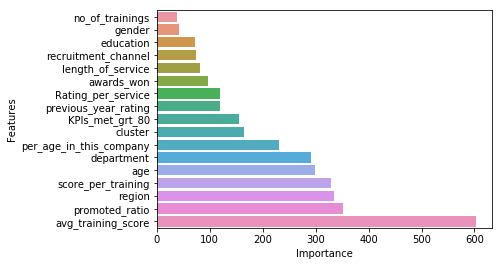

In [40]:
lg = lgb.LGBMClassifier(silent=False)

params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          #'metric': 'binary_logloss',
          'num_leaves': 2**4,
          'max_depth' : 4,
          'learning_rate': 0.09,
          'feature_fraction': 0.8,
          'bagging_fraction': 1,
          #'bagging_freq': 5,
          'verbose': 1
         }
lgb_train_prod = lgb.Dataset(train_prod_X, train_prod_Y,
                            categorical_feature = cat_columns,
                            free_raw_data=False )

nrounds = int(195/0.8)

lg = lgb.train(params,
               lgb_train_prod,
               num_boost_round =  nrounds,
               verbose_eval = 10)

lgb_predict = lg.predict(test_prod_X)
lgb_predict = (lgb_predict > 0.3).astype(int)


sub_LGB = pd.DataFrame({'employee_id' : sub_id,
                        'is_promoted' : lgb_predict})

sub_LGB.to_csv('sub_LGB_14.csv', index = False)

lgb_imt = pd.DataFrame({'Features' : indep, 
                        'Importance' : lg.feature_importance()}).sort_values(['Importance'])

plt.figure()
#plt.barh(F_impt.indep, F_impt.importance, order = F_impt['importance'])
sns.barplot(lgb_imt.Importance, lgb_imt.Features)
plt.show()


In [41]:
shap.initjs()
explainer = shap.TreeExplainer(lg)
shap_values = explainer.shap_values(train_prod_X)
shap.force_plot(explainer.expected_value, shap_values[0,:], train_prod_X.iloc[0,:])

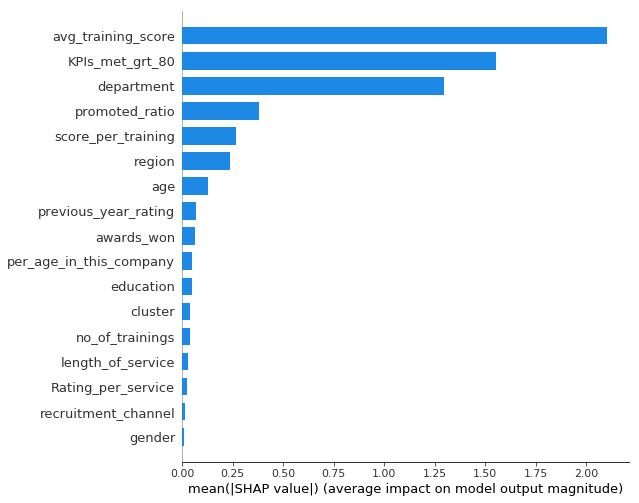

In [42]:
shap.summary_plot(shap_values, train_prod_X, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, train_prod_X)

In [22]:
train_prod_X.columns

Index(['KPIs_met_grt_80', 'Rating_per_service', 'age', 'avg_training_score',
       'awards_won', 'cluster', 'department', 'education', 'gender',
       'length_of_service', 'no_of_trainings', 'per_age_in_this_company',
       'previous_year_rating', 'promoted_ratio', 'recruitment_channel',
       'region', 'score_per_training', 'training_vs_service'],
      dtype='object')

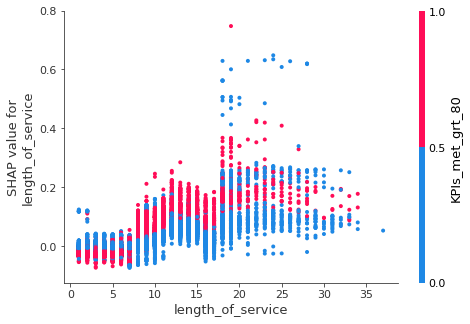

In [23]:
shap.dependence_plot('length_of_service', shap_values, train_prod_X)